In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
import os

# Definir la ruta de tu proyecto en Google Drive
project_path = '/content/drive/My Drive/tradingcripto/src'

# Definir la ruta del archivo de datos
data_file_path = os.path.join(project_path, '/content/drive/My Drive/tradingcripto/data/processed/BTCUSDT_prepared_data.pkl')

# Verificar si el archivo existe
if os.path.exists(data_file_path):
    print(f"El archivo {data_file_path} existe.")
else:
    print(f"El archivo {data_file_path} no se encuentra.")


El archivo /content/drive/My Drive/tradingcripto/data/processed/BTCUSDT_prepared_data.pkl existe.


In [13]:
import ccxt
import pandas as pd
import time
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
from binance.client import Client
import requests
import ta
import talib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

ModuleNotFoundError: No module named 'binance.client'; 'binance' is not a package

In [ ]:
load_dotenv()  # Esto carga las variables de entorno desde `.env`

api_key = os.getenv('BINANCE_API_KEY')
api_secret = os.getenv('BINANCE_API_SECRET')

In [ ]:
client = Client(api_key, api_secret)

def fetch_binance_data(symbol, interval, limit=1000):
    bars = client.get_historical_klines(symbol, interval, "1 Jan, 2017", limit=limit)
    df = pd.DataFrame(bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']]
    return df

symbols = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT']
intervals = ['1h']  # Solo intervalos horarios

data = {}  # Diccionario para almacenar DataFrames
raw_data_dir = "/content/drive/My Drive/tradingcripto/data/raw"
os.makedirs(raw_data_dir, exist_ok=True)

for symbol in symbols:
    data[symbol] = {}
    for interval in intervals:
        try:
            print(f"Fetching data for {symbol} at interval {interval}")
            df = fetch_binance_data(symbol, interval)
            data[symbol][interval] = df
            # Guardar los datos descargados
            df.to_csv(f"/content/drive/My Drive/tradingcripto/data/raw/{symbol}_{interval}.csv")
            print(f"Data fetched and saved for {symbol} at interval {interval}. Data shape: {df.shape}")
            time.sleep(60)  # Delay para no violar los límites de la API
        except Exception as e:
            print(f"Error fetching data for {symbol} at interval {interval}: {str(e)}")


In [ ]:
output_dir = "/content/drive/My Drive/tradingcripto/data/interim"
raw_data_dir = "/content/drive/My Drive/tradingcripto/data/raw"

In [ ]:
class CryptoDataProcessor:
    def __init__(self, df, symbol):
        self.df = df
        self.symbol = symbol
        # Inicialización basada en análisis de puntos extremos iniciales
        self.initialize_support_resistance()
        self.breakout_threshold = 0.01  # 1% por encima o por debajo


    def initialize_support_resistance(self):
        # Establecer soporte inicial como el mínimo de los primeros días
        self.support = min(self.df[f'{self.symbol}_low'].iloc[:30])
        # Establecer resistencia inicial como el máximo de los primeros días
        self.resistance = max(self.df[f'{self.symbol}_high'].iloc[:30])
        self.df[f'{self.symbol}_support'] = self.support
        self.df[f'{self.symbol}_resistance'] = self.resistance

    def update_support_resistance(self):
        # Crear columnas para soporte y resistencia dinámicos
        self.df[f'{self.symbol}_dynamic_support'] = self.support
        self.df[f'{self.symbol}_dynamic_resistance'] = self.resistance

        for index, row in self.df.iterrows():
            current_low = row[f'{self.symbol}_low']
            current_high = row[f'{self.symbol}_high']
            current_close = row[f'{self.symbol}_close']

            # Revisar y ajustar soporte y resistencia
            if current_close > self.resistance:
                self.support = self.resistance  # La resistencia rota se convierte en soporte
                self.resistance = current_high
            elif current_close < self.support:
                self.resistance = self.support  # El soporte roto se convierte en resistencia
                self.support = current_low

            # Actualizar el DataFrame con los valores dinámicos
            self.df.at[index, f'{self.symbol}_dynamic_support'] = self.support
            self.df.at[index, f'{self.symbol}_dynamic_resistance'] = self.resistance

    def add_technical_indicators(self):
        # Calcular SMAs y EMAs con manejo inicial dinámico para los datos iniciales limitados
        windows = [7, 14, 21, 28, 50, 100, 200]
        for i in windows:
            self.df[f'{self.symbol}_sma_{i}'] = self.df[f'{self.symbol}_close'].rolling(window=i, min_periods=1).mean()
            self.df[f'{self.symbol}_ema_{i}'] = self.df[f'{self.symbol}_close'].ewm(span=i, adjust=False, min_periods=1).mean()

        # RSI personalizado
        delta = self.df[f'{self.symbol}_close'].diff()
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)

        # Usar mean() con min_periods=1 asegura que calculamos el valor incluso si hay menos datos que la ventana
        avg_gain = gain.rolling(window=14, min_periods=1).mean()
        avg_loss = loss.rolling(window=14, min_periods=1).mean()

        rs = avg_gain / avg_loss
        self.df[f'{self.symbol}_rsi_14'] = 100.0 - (100.0 / (1.0 + rs))

        # MACD
        macd = ta.trend.MACD(self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_macd'] = macd.macd()
        self.df[f'{self.symbol}_macd_signal'] = macd.macd_signal()
        self.df[f'{self.symbol}_macd_diff'] = macd.macd_diff()

        # Williams %R
        self.df[f'{self.symbol}_willr'] = ta.momentum.williams_r(
            self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'], lbp=14)

        # ATR
        self.df[f'{self.symbol}_atr_14'] = ta.volatility.average_true_range(
            self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'], window=14)

        # Stochastic Oscillator
        # stoch_k, stoch_d = ta.momentum.stoch(
        #     self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'],
        #     window=14, smooth_window=3)
        # self.df[f'{self.symbol}_stoch'] = stoch_k
        # self.df[f'{self.symbol}_stoch_signal'] = stoch_d

        # ADX
        self.df[f'{self.symbol}_adx'] = ta.trend.adx(
            self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'], window=14)

        # Commodity Channel Index
        self.df[f'{self.symbol}_cci'] = ta.trend.cci(
            self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'], window=20)

        # Ichimoku
        ichimoku = ta.trend.IchimokuIndicator(
            high=self.df[f'{self.symbol}_high'], low=self.df[f'{self.symbol}_low'], window1=9, window2=26, window3=52)
        self.df[f'{self.symbol}_ichimoku_a'] = ichimoku.ichimoku_a()
        self.df[f'{self.symbol}_ichimoku_b'] = ichimoku.ichimoku_b()

        # Momentum
        for i in [10, 14, 20, 30]:
            self.df[f'{self.symbol}_momentum_{i}'] = ta.momentum.roc(self.df[f'{self.symbol}_close'], window=i)

        # Keltner Channel
        keltner = ta.volatility.KeltnerChannel(
            high=self.df[f'{self.symbol}_high'], low=self.df[f'{self.symbol}_low'], close=self.df[f'{self.symbol}_close'], window=20, window_atr=10)
        self.df[f'{self.symbol}_keltner_hband'] = keltner.keltner_channel_hband()
        self.df[f'{self.symbol}_keltner_lband'] = keltner.keltner_channel_lband()


    def add_candle_patterns(self):
    # Patrones básicos y comunes
        self.df[f'{self.symbol}_doji'] = talib.CDLDOJI(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_engulfing'] = talib.CDLENGULFING(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_hammer'] = talib.CDLHAMMER(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_inverted_hammer'] = talib.CDLINVERTEDHAMMER(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_hanging_man'] = talib.CDLHANGINGMAN(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_shooting_star'] = talib.CDLSHOOTINGSTAR(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_morning_star'] = talib.CDLMORNINGSTAR(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_evening_star'] = talib.CDLEVENINGSTAR(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_morning_doji_star'] = talib.CDLMORNINGDOJISTAR(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_evening_doji_star'] = talib.CDLEVENINGDOJISTAR(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])

    # Patrones complejos
        self.df[f'{self.symbol}_piercing_line'] = talib.CDLPIERCING(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_dark_cloud_cover'] = talib.CDLDARKCLOUDCOVER(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_three_white_soldiers'] = talib.CDL3WHITESOLDIERS(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_three_black_crows'] = talib.CDL3BLACKCROWS(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_three_inside_up_down'] = talib.CDL3INSIDE(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_three_outside_up_down'] = talib.CDL3OUTSIDE(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_three_stars_in_the_south'] = talib.CDL3STARSINSOUTH(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])
        self.df[f'{self.symbol}_three_advancing_white_soldiers'] = talib.CDL3WHITESOLDIERS(
        self.df[f'{self.symbol}_open'], self.df[f'{self.symbol}_high'], self.df[f'{self.symbol}_low'], self.df[f'{self.symbol}_close'])

    def process(self):
        self.add_technical_indicators()
        self.add_candle_patterns()
        self.update_support_resistance()
        # Añadir el precio de cierre de la siguiente hora como variable a predecir
        self.df[f'{self.symbol}_next_close'] = self.df[f'{self.symbol}_close'].shift(-1)
        return self.df

# Código para cargar y renombrar los DataFrames correctamente
data = {}
symbols = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT']
for symbol in symbols:
    file_path = f"/content/drive/My Drive/tradingcripto/data/raw/{symbol}_1h.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
        # Añadir el prefijo del símbolo a las columnas
        df.columns = [f"{symbol}_{col}" for col in df.columns]
        data[symbol] = df
    else:
        print(f"No data file found for {symbol}")

processed_data = {symbol: CryptoDataProcessor(data[symbol], symbol).process()
                  for symbol in data}

# Opcional: Guardar cada DataFrame procesado en un archivo CSV separado
for symbol, df in processed_data.items():
    df.to_csv(f"/content/drive/My Drive/tradingcripto/data/processed/{symbol}_processed.csv")

In [ ]:
# Función para verificar nombres de columnas
def check_column_names(symbol, output_dir):
    file_path = f"/content/drive/My Drive/tradingcripto/data/processed/{symbol}_processed.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
        print(f"Column names for {symbol}:")
        print(df.columns)
    else:
        print(f"No data file found for {symbol}")

# Verificar nombres de columnas para una criptomoneda
symbol = 'BTCUSDT'
output_dir = "/content/drive/My Drive/tradingcripto/data/interim"
check_column_names(symbol, output_dir)

In [ ]:
# Función para cargar datos procesados
def load_processed_data(symbols, output_dir):
    data = {}
    for symbol in symbols:
        file_path = f"/content/drive/My Drive/tradingcripto/data/processed/{symbol}_processed.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
            data[symbol] = df
        else:
            print(f"No data file found for {symbol}")
    return data

# Función para realizar EDA
def eda(df, symbol):
    print(f"--- {symbol} ---")

    # Estadísticas descriptivas
    print(df.describe())

    # Visualización de precios
    plt.figure(figsize=(14, 7))
    plt.plot(df[f'{symbol}_close'], label='Cierre')
    plt.plot(df[f'{symbol}_sma_50'], label='SMA 50')
    plt.plot(df[f'{symbol}_ema_50'], label='EMA 50')
    plt.title(f'Precio de Cierre y Medias Móviles de {symbol}')
    plt.legend()
    plt.show()

    # Histograma del volumen
    plt.figure(figsize=(14, 7))
    df[f'{symbol}_volume'].hist(bins=50)
    plt.title(f'Histograma del Volumen de {symbol}')
    plt.show()

    # Heatmap de correlaciones
    plt.figure(figsize=(14, 7))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title(f'Mapa de Calor de Correlaciones de {symbol}')
    plt.show()

    # Análisis de Tendencias y Estacionalidad
    result = seasonal_decompose(df[f'{symbol}_close'], model='multiplicative', period=24)
    result.plot()
    plt.show()

# Cargar los datos procesados
symbols = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT']
output_dir = "/content/drive/My Drive/tradingcripto/data/interim"
data = load_processed_data(symbols, output_dir)

# Realizar EDA para cada criptomoneda
for symbol in symbols:
    eda(data[symbol], symbol)

In [ ]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import json

# Función para cargar datos procesados
def load_processed_data(symbols, output_dir):
    data = {}
    for symbol in symbols:
        file_path = f"/content/drive/My Drive/tradingcripto/data/interim/{symbol}_processed.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
            data[symbol] = df
        else:
            print(f"No data file found for {symbol}")
    return data

# Cargar los datos procesados
symbols = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT']
output_dir = "/content/drive/My Drive/tradingcripto/data/interim"
data = load_processed_data(symbols, output_dir)

In [ ]:
# Verificar datos cargados
for symbol in symbols:
    print(f"Primeras filas de los datos para {symbol}:")
    display(data[symbol].head())
    print(f"Resumen de datos para {symbol}:")
    display(data[symbol].describe())
    print(f"Valores NaN en los datos para {symbol}:")
    display(data[symbol].isna().sum())

Primeras filas de los datos para BTCUSDT:


,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume,BTCUSDT_support,BTCUSDT_resistance,BTCUSDT_sma_7,BTCUSDT_ema_7,BTCUSDT_sma_14,...,BTCUSDT_dark_cloud_cover,BTCUSDT_three_white_soldiers,BTCUSDT_three_black_crows,BTCUSDT_three_inside_up_down,BTCUSDT_three_outside_up_down,BTCUSDT_three_stars_in_the_south,BTCUSDT_three_advancing_white_soldiers,BTCUSDT_dynamic_support,BTCUSDT_dynamic_resistance,BTCUSDT_next_close
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,4134.61,4485.39,4308.830000,4308.830000,4308.830000,...,0,0,0,0,0,0,0,4134.61,4485.39,4315.32
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,4134.61,4485.39,4312.075000,4310.452500,4312.075000,...,0,0,0,0,0,0,0,4134.61,4485.39,4324.35
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,4134.61,4485.39,4316.166667,4313.926875,4316.166667,...,0,0,0,0,0,0,0,4134.61,4485.39,4349.99
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,4134.61,4485.39,4324.622500,4322.942656,4324.622500,...,0,0,0,0,0,0,0,4134.61,4485.39,4360.69
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,4134.61,4485.39,4331.836000,4332.379492,4331.836000,...,0,0,0,0,100,0,0,4134.61,4485.39,4444.00


Resumen de datos para BTCUSDT:


,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume,BTCUSDT_support,BTCUSDT_resistance,BTCUSDT_sma_7,BTCUSDT_ema_7,BTCUSDT_sma_14,...,BTCUSDT_dark_cloud_cover,BTCUSDT_three_white_soldiers,BTCUSDT_three_black_crows,BTCUSDT_three_inside_up_down,BTCUSDT_three_outside_up_down,BTCUSDT_three_stars_in_the_south,BTCUSDT_three_advancing_white_soldiers,BTCUSDT_dynamic_support,BTCUSDT_dynamic_resistance,BTCUSDT_next_close
count,58494.000000,58494.000000,58494.000000,58494.000000,58494.000000,58494.00,58494.00,58494.000000,58494.000000,58494.000000,...,58494.000000,58494.000000,58494.000000,58494.000000,58494.00000,58494.0,58494.000000,58494.000000,58494.000000,58493.000000
mean,22566.475445,22679.784565,22446.430655,22567.504290,3006.707509,4134.61,4485.39,22564.389905,22564.374069,22560.693736,...,-0.013677,0.042739,-0.003419,-0.018805,0.12309,0.0,0.042739,22401.489334,22717.630959,22567.816441
std,17403.579594,17490.211293,17311.787339,17404.298728,4261.802814,0.00,0.00,17400.710259,17399.992160,17396.611351,...,1.169401,2.066927,0.584730,8.563980,18.72042,0.0,2.066927,17293.651854,17498.603560,17404.283760
min,2870.900000,2950.000000,2817.000000,2919.000000,0.000000,4134.61,4485.39,3068.214286,3052.613924,3196.757857,...,-100.000000,0.000000,-100.000000,-100.000000,-100.00000,0.0,0.000000,2915.010000,3100.000000,2919.000000
25%,8115.165000,8150.000000,8071.655000,8115.835000,955.062960,4134.61,4485.39,8109.659286,8109.942129,8109.198393,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,8055.050000,8160.000000,8115.880000
50%,16878.715000,16940.000000,16830.345000,16878.635000,1663.136608,4134.61,4485.39,16864.388571,16862.083475,16859.099643,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,16826.130000,16962.700000,16878.800000
75%,34777.817500,35000.000000,34560.690000,34778.160000,3225.397191,4134.61,4485.39,34760.040357,34769.135910,34809.446071,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,34628.932500,34999.735000,34778.180000
max,73577.350000,73777.000000,73215.140000,73577.350000,137207.188600,4134.61,4485.39,73260.531429,73253.927252,73141.487143,...,0.000000,100.000000,0.000000,100.000000,100.00000,0.0,100.000000,73263.990000,73650.250000,73577.350000


Valores NaN en los datos para BTCUSDT:


BTCUSDT_open                               0
BTCUSDT_high                               0
BTCUSDT_low                                0
BTCUSDT_close                              0
BTCUSDT_volume                             0
BTCUSDT_support                            0
BTCUSDT_resistance                         0
BTCUSDT_sma_7                              0
BTCUSDT_ema_7                              0
BTCUSDT_sma_14                             0
BTCUSDT_ema_14                             0
BTCUSDT_sma_21                             0
BTCUSDT_ema_21                             0
BTCUSDT_sma_28                             0
BTCUSDT_ema_28                             0
BTCUSDT_sma_50                             0
BTCUSDT_ema_50                             0
BTCUSDT_sma_100                            0
BTCUSDT_ema_100                            0
BTCUSDT_sma_200                            0
BTCUSDT_ema_200                            0
BTCUSDT_rsi_14                             1
BTCUSDT_ma

Primeras filas de los datos para ETHUSDT:


,ETHUSDT_open,ETHUSDT_high,ETHUSDT_low,ETHUSDT_close,ETHUSDT_volume,ETHUSDT_support,ETHUSDT_resistance,ETHUSDT_sma_7,ETHUSDT_ema_7,ETHUSDT_sma_14,...,ETHUSDT_dark_cloud_cover,ETHUSDT_three_white_soldiers,ETHUSDT_three_black_crows,ETHUSDT_three_inside_up_down,ETHUSDT_three_outside_up_down,ETHUSDT_three_stars_in_the_south,ETHUSDT_three_advancing_white_soldiers,ETHUSDT_dynamic_support,ETHUSDT_dynamic_resistance,ETHUSDT_next_close
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.0,301.61,125.66877,295.19,312.18,301.610000,301.610000,301.610000,...,0,0,0,0,0,0,0,295.19,312.18,303.10
2017-08-17 05:00:00,301.61,303.28,300.0,303.10,377.67246,295.19,312.18,302.355000,301.982500,302.355000,...,0,0,0,0,0,0,0,295.19,312.18,302.68
2017-08-17 06:00:00,302.40,304.44,301.9,302.68,303.86672,295.19,312.18,302.463333,302.156875,302.463333,...,0,0,0,0,0,0,0,295.19,312.18,307.96
2017-08-17 07:00:00,302.68,307.96,302.6,307.96,754.74510,295.19,312.18,303.837500,303.607656,303.837500,...,0,0,0,0,0,0,0,295.19,312.18,308.62
2017-08-17 08:00:00,307.95,309.97,307.0,308.62,150.75029,295.19,312.18,304.794000,304.860742,304.794000,...,0,0,0,0,0,0,0,295.19,312.18,310.00


Resumen de datos para ETHUSDT:


,ETHUSDT_open,ETHUSDT_high,ETHUSDT_low,ETHUSDT_close,ETHUSDT_volume,ETHUSDT_support,ETHUSDT_resistance,ETHUSDT_sma_7,ETHUSDT_ema_7,ETHUSDT_sma_14,...,ETHUSDT_dark_cloud_cover,ETHUSDT_three_white_soldiers,ETHUSDT_three_black_crows,ETHUSDT_three_inside_up_down,ETHUSDT_three_outside_up_down,ETHUSDT_three_stars_in_the_south,ETHUSDT_three_advancing_white_soldiers,ETHUSDT_dynamic_support,ETHUSDT_dynamic_resistance,ETHUSDT_next_close
count,58494.000000,58494.000000,58494.000000,58494.000000,58494.000000,58494.00,58494.00,58494.000000,58494.000000,58494.000000,...,58494.000000,58494.000000,58494.000000,58494.000000,58494.000000,58494.0,58494.000000,58494.000000,58494.000000,58493.000000
mean,1287.410446,1295.159878,1279.105003,1287.456404,22538.299429,295.19,312.18,1287.308107,1287.307350,1287.132031,...,-0.006838,0.052997,-0.008548,0.034192,0.073512,0.0,0.052997,1277.064267,1296.595559,1287.473259
std,1154.948156,1161.555649,1147.807983,1154.968730,27119.395386,0.00,0.00,1154.793526,1154.737785,1154.606024,...,0.826919,2.301515,0.924516,8.412879,18.743497,0.0,2.301515,1147.723602,1161.532336,1154.971410
min,82.160000,82.950000,81.790000,82.170000,0.000000,295.19,312.18,82.807143,82.888220,83.263571,...,-100.000000,0.000000,-100.000000,-100.000000,-100.000000,0.0,0.000000,81.790000,82.630000,82.170000
25%,243.312500,244.412500,242.010000,243.320000,7212.042338,295.19,312.18,243.328929,243.301411,243.253929,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,240.000000,248.800000,243.320000
50%,1052.795000,1065.000000,1039.635000,1052.630000,14432.974545,295.19,312.18,1053.942143,1053.697264,1053.774643,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1037.000000,1063.500000,1052.760000
75%,1911.810000,1919.700000,1903.527500,1911.810000,27932.351673,295.19,312.18,1911.095000,1910.356803,1909.100714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1903.470000,1920.200000,1911.810000
max,4846.940000,4868.000000,4833.190000,4846.710000,493227.882820,295.19,312.18,4809.317143,4810.289463,4800.784286,...,0.000000,100.000000,0.000000,100.000000,100.000000,0.0,100.000000,4822.970000,4868.000000,4846.710000


Valores NaN en los datos para ETHUSDT:


ETHUSDT_open                               0
ETHUSDT_high                               0
ETHUSDT_low                                0
ETHUSDT_close                              0
ETHUSDT_volume                             0
ETHUSDT_support                            0
ETHUSDT_resistance                         0
ETHUSDT_sma_7                              0
ETHUSDT_ema_7                              0
ETHUSDT_sma_14                             0
ETHUSDT_ema_14                             0
ETHUSDT_sma_21                             0
ETHUSDT_ema_21                             0
ETHUSDT_sma_28                             0
ETHUSDT_ema_28                             0
ETHUSDT_sma_50                             0
ETHUSDT_ema_50                             0
ETHUSDT_sma_100                            0
ETHUSDT_ema_100                            0
ETHUSDT_sma_200                            0
ETHUSDT_ema_200                            0
ETHUSDT_rsi_14                             1
ETHUSDT_ma

Primeras filas de los datos para XRPUSDT:


,XRPUSDT_open,XRPUSDT_high,XRPUSDT_low,XRPUSDT_close,XRPUSDT_volume,XRPUSDT_support,XRPUSDT_resistance,XRPUSDT_sma_7,XRPUSDT_ema_7,XRPUSDT_sma_14,...,XRPUSDT_dark_cloud_cover,XRPUSDT_three_white_soldiers,XRPUSDT_three_black_crows,XRPUSDT_three_inside_up_down,XRPUSDT_three_outside_up_down,XRPUSDT_three_stars_in_the_south,XRPUSDT_three_advancing_white_soldiers,XRPUSDT_dynamic_support,XRPUSDT_dynamic_resistance,XRPUSDT_next_close
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-05-04 08:00:00,0.50000,1.50000,0.5000,0.92300,5090857.33,0.5,1.5,0.923000,0.923000,0.923000,...,0,0,0,0,0,0,0,0.5,1.5,0.90199
2018-05-04 09:00:00,0.92300,0.92850,0.9010,0.90199,3326696.10,0.5,1.5,0.912495,0.917748,0.912495,...,0,0,0,0,0,0,0,0.5,1.5,0.90128
2018-05-04 10:00:00,0.90199,0.91027,0.8951,0.90128,1176810.48,0.5,1.5,0.908757,0.913631,0.908757,...,0,0,0,0,0,0,0,0.5,1.5,0.91596
2018-05-04 11:00:00,0.90128,0.92130,0.8800,0.91596,1714233.92,0.5,1.5,0.910558,0.914213,0.910558,...,0,0,0,0,0,0,0,0.5,1.5,0.90098
2018-05-04 12:00:00,0.91596,0.92450,0.9000,0.90098,1323800.17,0.5,1.5,0.908642,0.910905,0.908642,...,0,0,0,0,0,0,0,0.5,1.5,0.89722


Resumen de datos para XRPUSDT:


,XRPUSDT_open,XRPUSDT_high,XRPUSDT_low,XRPUSDT_close,XRPUSDT_volume,XRPUSDT_support,XRPUSDT_resistance,XRPUSDT_sma_7,XRPUSDT_ema_7,XRPUSDT_sma_14,...,XRPUSDT_dark_cloud_cover,XRPUSDT_three_white_soldiers,XRPUSDT_three_black_crows,XRPUSDT_three_inside_up_down,XRPUSDT_three_outside_up_down,XRPUSDT_three_stars_in_the_south,XRPUSDT_three_advancing_white_soldiers,XRPUSDT_dynamic_support,XRPUSDT_dynamic_resistance,XRPUSDT_next_close
count,52290.000000,52290.000000,52290.000000,52290.000000,5.229000e+04,52290.0,52290.0,52290.000000,52290.000000,52290.000000,...,52290.000000,52290.000000,52290.000000,52290.000000,52290.000000,52290.0,52290.000000,52290.000000,52290.000000,52289.000000
mean,0.491889,0.495534,0.487945,0.491892,1.522801e+07,0.5,1.5,0.491914,0.491914,0.491938,...,-0.009562,0.053548,-0.005737,-0.034423,-0.042073,0.0,0.053548,0.479736,0.518382,0.491883
std,0.265908,0.269040,0.262502,0.265908,2.681365e+07,0.0,0.0,0.265815,0.265764,0.265729,...,0.977820,2.313436,0.757431,8.320423,18.687195,0.0,2.313436,0.261169,0.306177,0.265904
min,0.119400,0.133570,0.101290,0.119420,0.000000e+00,0.5,1.5,0.132620,0.136725,0.138813,...,-100.000000,0.000000,-100.000000,-100.000000,-100.000000,0.0,0.000000,0.117820,0.127980,0.119420
25%,0.302963,0.304800,0.301250,0.302980,3.572473e+06,0.5,1.5,0.302899,0.302940,0.302862,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.297900,0.310400,0.302980
50%,0.432700,0.436270,0.428815,0.432630,8.637097e+06,0.5,1.5,0.433064,0.433074,0.433263,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.422600,0.438700,0.432620
75%,0.605690,0.609600,0.601070,0.605683,1.685023e+07,0.5,1.5,0.605725,0.605631,0.605898,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.582000,0.616200,0.605630
max,1.937770,1.966890,1.890000,1.937770,1.404208e+09,0.5,1.5,1.867696,1.869330,1.833850,...,0.000000,100.000000,0.000000,100.000000,100.000000,0.0,100.000000,1.830000,1.943210,1.937770


Valores NaN en los datos para XRPUSDT:


XRPUSDT_open                               0
XRPUSDT_high                               0
XRPUSDT_low                                0
XRPUSDT_close                              0
XRPUSDT_volume                             0
XRPUSDT_support                            0
XRPUSDT_resistance                         0
XRPUSDT_sma_7                              0
XRPUSDT_ema_7                              0
XRPUSDT_sma_14                             0
XRPUSDT_ema_14                             0
XRPUSDT_sma_21                             0
XRPUSDT_ema_21                             0
XRPUSDT_sma_28                             0
XRPUSDT_ema_28                             0
XRPUSDT_sma_50                             0
XRPUSDT_ema_50                             0
XRPUSDT_sma_100                            0
XRPUSDT_ema_100                            0
XRPUSDT_sma_200                            0
XRPUSDT_ema_200                            0
XRPUSDT_rsi_14                             1
XRPUSDT_ma

Primeras filas de los datos para LTCUSDT:


,LTCUSDT_open,LTCUSDT_high,LTCUSDT_low,LTCUSDT_close,LTCUSDT_volume,LTCUSDT_support,LTCUSDT_resistance,LTCUSDT_sma_7,LTCUSDT_ema_7,LTCUSDT_sma_14,...,LTCUSDT_dark_cloud_cover,LTCUSDT_three_white_soldiers,LTCUSDT_three_black_crows,LTCUSDT_three_inside_up_down,LTCUSDT_three_outside_up_down,LTCUSDT_three_stars_in_the_south,LTCUSDT_three_advancing_white_soldiers,LTCUSDT_dynamic_support,LTCUSDT_dynamic_resistance,LTCUSDT_next_close
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-12-13 03:00:00,272.00,288.00,272.00,276.00,130.86075,260.0,330.0,276.000000,276.000000,276.000000,...,0,0,0,0,0,0,0,260.0,330.0,279.00
2017-12-13 04:00:00,276.00,288.00,269.99,279.00,606.48130,260.0,330.0,277.500000,276.750000,277.500000,...,0,0,0,0,0,0,0,260.0,330.0,302.00
2017-12-13 05:00:00,279.00,330.00,279.00,302.00,383.76674,260.0,330.0,285.666667,283.062500,285.666667,...,0,0,0,0,0,0,0,260.0,330.0,291.13
2017-12-13 06:00:00,302.00,304.11,286.00,291.13,351.59475,260.0,330.0,287.032500,285.079375,287.032500,...,0,0,0,0,0,0,0,260.0,330.0,287.00
2017-12-13 07:00:00,291.13,296.00,285.00,287.00,165.12420,260.0,330.0,287.026000,285.559531,287.026000,...,0,0,0,0,0,0,0,260.0,330.0,280.10


Resumen de datos para LTCUSDT:


,LTCUSDT_open,LTCUSDT_high,LTCUSDT_low,LTCUSDT_close,LTCUSDT_volume,LTCUSDT_support,LTCUSDT_resistance,LTCUSDT_sma_7,LTCUSDT_ema_7,LTCUSDT_sma_14,...,LTCUSDT_dark_cloud_cover,LTCUSDT_three_white_soldiers,LTCUSDT_three_black_crows,LTCUSDT_three_inside_up_down,LTCUSDT_three_outside_up_down,LTCUSDT_three_stars_in_the_south,LTCUSDT_three_advancing_white_soldiers,LTCUSDT_dynamic_support,LTCUSDT_dynamic_resistance,LTCUSDT_next_close
count,55669.000000,55669.000000,55669.000000,55669.000000,5.566900e+04,55669.0,55669.0,55669.000000,55669.000000,55669.000000,...,55669.000000,55669.000000,55669.000000,55669.000000,55669.000000,55669.0,55669.000000,55669.000000,55669.000000,55668.000000
mean,96.825744,97.629923,95.966897,96.821670,2.729789e+04,260.0,330.0,96.832242,96.831938,96.844756,...,-0.012574,0.057483,-0.003593,-0.030538,-0.176041,0.0,0.057483,95.257045,98.434897,96.818451
std,57.292218,58.094977,56.448449,57.287209,3.853210e+04,0.0,0.0,57.278751,57.267445,57.276543,...,1.121292,2.396886,0.599383,8.423506,18.541659,0.0,2.396886,56.577588,58.267536,57.282690
min,22.740000,22.880000,22.320000,22.750000,0.000000e+00,260.0,330.0,22.840000,22.904619,23.093571,...,-100.000000,0.000000,-100.000000,-100.000000,-100.000000,0.0,0.000000,22.500000,22.900000,22.750000
25%,56.970000,57.360000,56.600000,56.970000,8.023512e+03,260.0,330.0,56.987143,56.959415,56.960000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,56.000000,57.660000,56.967500
50%,76.950000,77.400000,76.410000,76.950000,1.576473e+04,260.0,330.0,76.977143,76.995894,77.000714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,76.180000,77.960000,76.950000
75%,121.790000,122.730000,120.800000,121.730000,3.157753e+04,260.0,330.0,121.671429,121.633992,121.662857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,120.600000,122.730000,121.730000
max,409.830000,413.490000,402.800000,409.840000,2.249842e+06,260.0,330.0,403.257143,399.102239,397.683571,...,0.000000,100.000000,0.000000,100.000000,100.000000,0.0,100.000000,403.880000,413.490000,409.840000


Valores NaN en los datos para LTCUSDT:


LTCUSDT_open                               0
LTCUSDT_high                               0
LTCUSDT_low                                0
LTCUSDT_close                              0
LTCUSDT_volume                             0
LTCUSDT_support                            0
LTCUSDT_resistance                         0
LTCUSDT_sma_7                              0
LTCUSDT_ema_7                              0
LTCUSDT_sma_14                             0
LTCUSDT_ema_14                             0
LTCUSDT_sma_21                             0
LTCUSDT_ema_21                             0
LTCUSDT_sma_28                             0
LTCUSDT_ema_28                             0
LTCUSDT_sma_50                             0
LTCUSDT_ema_50                             0
LTCUSDT_sma_100                            0
LTCUSDT_ema_100                            0
LTCUSDT_sma_200                            0
LTCUSDT_ema_200                            0
LTCUSDT_rsi_14                             1
LTCUSDT_ma

# Función para calcular la matriz de correlación y eliminar características redundantes
def remove_highly_correlated_features(df, symbol, target_column, threshold=0.9):
    # Asegurarse de que las columnas esenciales no se eliminan
    essential_columns = {f'{symbol}_open', f'{symbol}_high', f'{symbol}_low', target_column}

    # Separar las columnas categóricas y numéricas
    categorical_columns = [col for col in df.columns if 'CDL' in col or 'doji' in col or 'engulfing' in col or 'hammer' in col or 'star' in col or 'three' in col or 'line' in col or 'cover' in col]
    numerical_columns = [col for col in df.columns if col not in categorical_columns]

    # Crear una máscara para preservar las columnas esenciales
    preserve_mask = df[numerical_columns].columns.isin(essential_columns)

    # Calcular la matriz de correlación sin las columnas esenciales
    corr_matrix = df[numerical_columns].loc[:, ~preserve_mask].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = []

    # Determinar los grupos de características altamente correlacionadas
    for column in upper.columns:
        correlated_columns = upper.index[upper[column] > threshold].tolist()
        if correlated_columns:
            correlated_columns.append(column)
            # Seleccionar la característica con mayor correlación con la variable objetivo
            correlated_columns_with_target = df[correlated_columns + [target_column]].corr()[target_column].abs().sort_values(ascending=False).index.tolist()
            correlated_columns_with_target.remove(target_column)
            most_correlated = correlated_columns_with_target[0]
            correlated_columns.remove(most_correlated)
            to_drop.extend(correlated_columns)

    # Eliminar las características menos relevantes
    df = df.drop(columns=to_drop)

    # Añadir de vuelta las características categóricas
    df = pd.concat([df, df[categorical_columns]], axis=1)

    return df, to_drop

# Eliminar características altamente correlacionadas para cada criptomoneda
for symbol in symbols:
    print(f"Eliminando características altamente correlacionadas para {symbol}")
    target_column = f'{symbol}_next_close'
    df, to_drop = remove_highly_correlated_features(data[symbol], symbol, target_column)
    print(f"Características eliminadas por correlación para {symbol}:\n{to_drop}\n")
    data[symbol] = df

In [ ]:
# Verificar valores NaN después de la eliminación de características correlacionadas
for symbol in symbols:
    print(f"Valores NaN en los datos reducidos para {symbol}:")
    display(data[symbol].isna().sum())

    # Rellenar valores NaN con el valor más cercano
    if data[symbol].isna().sum().sum() > 0:
        print(f"Rellenando valores NaN para {symbol}")
        data[symbol].fillna(method='ffill', inplace=True)
        data[symbol].fillna(method='bfill', inplace=True)
        display(data[symbol].isna().sum())


Valores NaN en los datos reducidos para BTCUSDT:


BTCUSDT_open                               0
BTCUSDT_high                               0
BTCUSDT_low                                0
BTCUSDT_close                              0
BTCUSDT_volume                             0
BTCUSDT_support                            0
BTCUSDT_resistance                         0
BTCUSDT_sma_7                              0
BTCUSDT_ema_7                              0
BTCUSDT_sma_14                             0
BTCUSDT_ema_14                             0
BTCUSDT_sma_21                             0
BTCUSDT_ema_21                             0
BTCUSDT_sma_28                             0
BTCUSDT_ema_28                             0
BTCUSDT_sma_50                             0
BTCUSDT_ema_50                             0
BTCUSDT_sma_100                            0
BTCUSDT_ema_100                            0
BTCUSDT_sma_200                            0
BTCUSDT_ema_200                            0
BTCUSDT_rsi_14                             1
BTCUSDT_ma

Rellenando valores NaN para BTCUSDT


BTCUSDT_open                              0
BTCUSDT_high                              0
BTCUSDT_low                               0
BTCUSDT_close                             0
BTCUSDT_volume                            0
BTCUSDT_support                           0
BTCUSDT_resistance                        0
BTCUSDT_sma_7                             0
BTCUSDT_ema_7                             0
BTCUSDT_sma_14                            0
BTCUSDT_ema_14                            0
BTCUSDT_sma_21                            0
BTCUSDT_ema_21                            0
BTCUSDT_sma_28                            0
BTCUSDT_ema_28                            0
BTCUSDT_sma_50                            0
BTCUSDT_ema_50                            0
BTCUSDT_sma_100                           0
BTCUSDT_ema_100                           0
BTCUSDT_sma_200                           0
BTCUSDT_ema_200                           0
BTCUSDT_rsi_14                            0
BTCUSDT_macd                    

Valores NaN en los datos reducidos para ETHUSDT:


ETHUSDT_open                               0
ETHUSDT_high                               0
ETHUSDT_low                                0
ETHUSDT_close                              0
ETHUSDT_volume                             0
ETHUSDT_support                            0
ETHUSDT_resistance                         0
ETHUSDT_sma_7                              0
ETHUSDT_ema_7                              0
ETHUSDT_sma_14                             0
ETHUSDT_ema_14                             0
ETHUSDT_sma_21                             0
ETHUSDT_ema_21                             0
ETHUSDT_sma_28                             0
ETHUSDT_ema_28                             0
ETHUSDT_sma_50                             0
ETHUSDT_ema_50                             0
ETHUSDT_sma_100                            0
ETHUSDT_ema_100                            0
ETHUSDT_sma_200                            0
ETHUSDT_ema_200                            0
ETHUSDT_rsi_14                             1
ETHUSDT_ma

Rellenando valores NaN para ETHUSDT


ETHUSDT_open                              0
ETHUSDT_high                              0
ETHUSDT_low                               0
ETHUSDT_close                             0
ETHUSDT_volume                            0
ETHUSDT_support                           0
ETHUSDT_resistance                        0
ETHUSDT_sma_7                             0
ETHUSDT_ema_7                             0
ETHUSDT_sma_14                            0
ETHUSDT_ema_14                            0
ETHUSDT_sma_21                            0
ETHUSDT_ema_21                            0
ETHUSDT_sma_28                            0
ETHUSDT_ema_28                            0
ETHUSDT_sma_50                            0
ETHUSDT_ema_50                            0
ETHUSDT_sma_100                           0
ETHUSDT_ema_100                           0
ETHUSDT_sma_200                           0
ETHUSDT_ema_200                           0
ETHUSDT_rsi_14                            0
ETHUSDT_macd                    

Valores NaN en los datos reducidos para XRPUSDT:


XRPUSDT_open                               0
XRPUSDT_high                               0
XRPUSDT_low                                0
XRPUSDT_close                              0
XRPUSDT_volume                             0
XRPUSDT_support                            0
XRPUSDT_resistance                         0
XRPUSDT_sma_7                              0
XRPUSDT_ema_7                              0
XRPUSDT_sma_14                             0
XRPUSDT_ema_14                             0
XRPUSDT_sma_21                             0
XRPUSDT_ema_21                             0
XRPUSDT_sma_28                             0
XRPUSDT_ema_28                             0
XRPUSDT_sma_50                             0
XRPUSDT_ema_50                             0
XRPUSDT_sma_100                            0
XRPUSDT_ema_100                            0
XRPUSDT_sma_200                            0
XRPUSDT_ema_200                            0
XRPUSDT_rsi_14                             1
XRPUSDT_ma

Rellenando valores NaN para XRPUSDT


XRPUSDT_open                              0
XRPUSDT_high                              0
XRPUSDT_low                               0
XRPUSDT_close                             0
XRPUSDT_volume                            0
XRPUSDT_support                           0
XRPUSDT_resistance                        0
XRPUSDT_sma_7                             0
XRPUSDT_ema_7                             0
XRPUSDT_sma_14                            0
XRPUSDT_ema_14                            0
XRPUSDT_sma_21                            0
XRPUSDT_ema_21                            0
XRPUSDT_sma_28                            0
XRPUSDT_ema_28                            0
XRPUSDT_sma_50                            0
XRPUSDT_ema_50                            0
XRPUSDT_sma_100                           0
XRPUSDT_ema_100                           0
XRPUSDT_sma_200                           0
XRPUSDT_ema_200                           0
XRPUSDT_rsi_14                            0
XRPUSDT_macd                    

Valores NaN en los datos reducidos para LTCUSDT:


LTCUSDT_open                               0
LTCUSDT_high                               0
LTCUSDT_low                                0
LTCUSDT_close                              0
LTCUSDT_volume                             0
LTCUSDT_support                            0
LTCUSDT_resistance                         0
LTCUSDT_sma_7                              0
LTCUSDT_ema_7                              0
LTCUSDT_sma_14                             0
LTCUSDT_ema_14                             0
LTCUSDT_sma_21                             0
LTCUSDT_ema_21                             0
LTCUSDT_sma_28                             0
LTCUSDT_ema_28                             0
LTCUSDT_sma_50                             0
LTCUSDT_ema_50                             0
LTCUSDT_sma_100                            0
LTCUSDT_ema_100                            0
LTCUSDT_sma_200                            0
LTCUSDT_ema_200                            0
LTCUSDT_rsi_14                             1
LTCUSDT_ma

Rellenando valores NaN para LTCUSDT


LTCUSDT_open                              0
LTCUSDT_high                              0
LTCUSDT_low                               0
LTCUSDT_close                             0
LTCUSDT_volume                            0
LTCUSDT_support                           0
LTCUSDT_resistance                        0
LTCUSDT_sma_7                             0
LTCUSDT_ema_7                             0
LTCUSDT_sma_14                            0
LTCUSDT_ema_14                            0
LTCUSDT_sma_21                            0
LTCUSDT_ema_21                            0
LTCUSDT_sma_28                            0
LTCUSDT_ema_28                            0
LTCUSDT_sma_50                            0
LTCUSDT_ema_50                            0
LTCUSDT_sma_100                           0
LTCUSDT_ema_100                           0
LTCUSDT_sma_200                           0
LTCUSDT_ema_200                           0
LTCUSDT_rsi_14                            0
LTCUSDT_macd                    

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import os

symbols = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT']

def prepare_data(df, target_column, sequence_length=50):
    # Seleccionar todas las columnas excepto la columna objetivo
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values

    feature_scaler = RobustScaler()
    target_scaler = RobustScaler()

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()

    X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

    split_index = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_index], X_seq[split_index:]
    y_train, y_test = y_seq[:split_index], y_seq[split_index:]

    print(f"Tamaño de X_train: {len(X_train)}, Tamaño de X_test: {len(X_test)}")
    print(f"Tamaño de y_train: {len(y_train)}, Tamaño de y_test: {len(y_test)}")

    # Guardar los datos preparados
    #prepared_data_path = os.path.join("..//content/drive/My Drive/tradingcripto/data/processed", f"{symbol}_prepared_data.pkl")
    #joblib.dump((X_train, X_test, y_train, y_test, feature_scaler, target_scaler), prepared_data_path)

    # Guardar los escaladores
    scaler_path = os.path.join("..//content/drive/My Drive/tradingcripto/data/processed", f"{symbol}_scalers.pkl")
    joblib.dump((feature_scaler, target_scaler), scaler_path)

     # Guardar un ejemplo de los datos procesados y escalados
    example_data_path = os.path.join("..//content/drive/My Drive/tradingcripto/data/processed", f"{symbol}_example_data.pkl")
    joblib.dump((X[:5], X_scaled[:5]), example_data_path)  # Guardar los primeros 5 ejemplos de datos

    return X_train, X_test, y_train, y_test, feature_scaler, target_scaler

def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X[i:i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(xs), np.array(ys)

# Función para verificar solapamiento
def check_overlap(train_data, test_data):
    train_set = set(map(tuple, train_data.reshape((train_data.shape[0], -1))))
    test_set = set(map(tuple, test_data.reshape((test_data.shape[0], -1))))
    overlap = train_set.intersection(test_set)
    return len(overlap) > 0

# Preparar datos para cada criptomoneda
sequence_length = 50
prepared_data = {}
for symbol in symbols:
    print(f"Preparando datos para {symbol}")
    target_column = f'{symbol}_next_close'
    # Utilizar todas las columnas excepto la columna objetivo
    X_train, X_test, y_train, y_test, feature_scaler, target_scaler = prepare_data(data[symbol], target_column, sequence_length)

    # Verificación de solapamiento
    if check_overlap(X_train, X_test):
        raise ValueError(f"Existe solapamiento entre los conjuntos de entrenamiento y validación para {symbol}")

    prepared_data[symbol] = (X_train, X_test, y_train, y_test, feature_scaler, target_scaler)
    prepared_data_path = os.path.join("..//content/drive/My Drive/tradingcripto/data/processed", f"{symbol}_prepared_data.pkl")
    joblib.dump((X_train, X_test, y_train, y_test, feature_scaler, target_scaler), prepared_data_path)

print("Datos preparados y guardados.")


Preparando datos para BTCUSDT
Tamaño de X_train: 46755, Tamaño de X_test: 11689
Tamaño de y_train: 46755, Tamaño de y_test: 11689
Preparando datos para ETHUSDT
Tamaño de X_train: 46755, Tamaño de X_test: 11689
Tamaño de y_train: 46755, Tamaño de y_test: 11689
Preparando datos para XRPUSDT
Tamaño de X_train: 41792, Tamaño de X_test: 10448
Tamaño de y_train: 41792, Tamaño de y_test: 10448
Preparando datos para LTCUSDT
Tamaño de X_train: 44495, Tamaño de X_test: 11124
Tamaño de y_train: 44495, Tamaño de y_test: 11124
Datos preparados y guardados.


In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import joblib
from tensorflow.keras.callbacks import ModelCheckpoint
import tempfile
import shutil

# Custom callback to print metrics
class MetricsLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch + 1}: loss = {logs.get('loss')}, val_loss = {logs.get('val_loss')}, "
              f"mse = {logs.get('mse')}, val_mse = {logs.get('val_mse')}, "
              f"mae = {logs.get('mae')}, val_mae = {logs.get('val_mae')}")

# Function to build the model based on the parameters
def build_model(input_shape, units=[256, 128, 64], dropout_rate=0.2, recurrent_dropout_rate=0.2, optimizer='rmsprop', model_type='GRU'):
    model = Sequential()
    model.add(Input(shape=input_shape))

    for i, unit in enumerate(units):
        if model_type == 'GRU':
            model.add(GRU(unit, return_sequences=(i < len(units) - 1), dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate))
        elif model_type == 'LSTM':
            model.add(LSTM(unit, return_sequences=(i < len(units) - 1), dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate))
        elif model_type == 'Bidirectional_LSTM':
            model.add(Bidirectional(LSTM(unit, return_sequences=(i < len(units) - 1), dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))  # Capa de salida con una unidad para la predicción del valor objetivo
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])
    return model


# Function to save metrics and hyperparameters
def save_metrics_and_params(symbol, model_dir, best_score, best_params):
    metrics_path = os.path.join(model_dir, f"{symbol}_best_metrics.txt")
    with open(metrics_path, 'w') as f:
        f.write(f"Best Score (MAE): {best_score}\n")
        f.write("Best Hyperparameters:\n")
        for param, value in best_params.items():
            f.write(f"{param}: {value}\n")

def train_and_evaluate(symbol, model_dir, param_grid, sequence_length):
    print(f"Entrenando y evaluando modelo para {symbol}")

    # Cargar los datos preparados
    prepared_data_path = os.path.join("..//content/drive/My Drive/tradingcripto/data/processed", f"{symbol}_prepared_data.pkl")
    X_train, X_test, y_train, y_test, feature_scaler, target_scaler = joblib.load(prepared_data_path)

    if check_overlap(X_train, X_test):
        raise ValueError(f"Existe solapamiento entre los conjuntos de entrenamiento y validación para {symbol}")

    input_shape = (X_train.shape[1], X_train.shape[2])

    # Definir la ruta para guardar el mejor modelo
    symbol_model_dir = os.path.join(model_dir, symbol)
    os.makedirs(symbol_model_dir, exist_ok=True)
    best_model_path = os.path.join(symbol_model_dir, "best_model.keras")

    # Configurar la validación cruzada
    tscv = TimeSeriesSplit(n_splits=3)

    # Variables para almacenar los mejores resultados
    best_score = float('inf')
    best_params = None
    best_model_path_temp = None

    # Iterar sobre las combinaciones de hiperparámetros
    for units in param_grid['units']:
        for dropout_rate in param_grid['dropout_rate']:
            for optimizer in param_grid['optimizer']:
                for model_type in param_grid['model_type']:
                    for epochs in param_grid['epochs']:
                        for batch_size in param_grid['batch_size']:
                            val_losses = []

                            # Validación cruzada
                            for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
                                X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                                # Definir el modelo
                                model = build_model(input_shape, units=units, dropout_rate=dropout_rate, optimizer=optimizer, model_type=model_type)

                                # Inicializar el callback para el checkpoint personalizado
                                early_stopping = EarlyStopping(monitor='val_mae', mode='min', patience=6, verbose=1)
                                metrics_logger = MetricsLogger()

                                # Definir la ruta para guardar el modelo del fold actual
                                fold_model_path = os.path.join(symbol_model_dir, f"model_{units}_{dropout_rate}_{optimizer}_{model_type}_{epochs}_{batch_size}_fold_{fold}.keras")
                                checkpoint = ModelCheckpoint(fold_model_path, monitor='val_mae', save_best_only=True, mode='min', verbose=1)

                                try:
                                    history = model.fit(
                                        X_train_fold, y_train_fold,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_data=(X_val_fold, y_val_fold),
                                        callbacks=[early_stopping, metrics_logger, checkpoint],
                                        verbose=0
                                    )

                                    val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)[2]  # Get MAE only
                                    val_losses.append(val_mae)

                                except ConnectionResetError as e:
                                    print(f"Connection error encountered: {e}. Retrying...")
                                    continue

                            mean_val_loss = np.mean(val_losses)
                            print(f"Mean validation loss (MAE) for {symbol} with {units} units, {dropout_rate} dropout, {optimizer} optimizer, {model_type} model, {epochs} epochs, and {batch_size} batch size: {mean_val_loss}")

                            # Guardar los mejores hiperparámetros y el mejor modelo según la media de val_mae
                            if mean_val_loss < best_score:
                                best_score = mean_val_loss
                                best_params = {
                                    'units': units,
                                    'dropout_rate': dropout_rate,
                                    'optimizer': optimizer,
                                    'model_type': model_type,
                                    'epochs': epochs,
                                    'batch_size': batch_size
                                }

                                # Guardar la ruta del mejor modelo
                                best_model_path_temp = fold_model_path

    # Mover el mejor modelo a la ubicación final
    if best_model_path_temp and best_model_path_temp != best_model_path:
        shutil.move(best_model_path_temp, best_model_path)

    # Guardar las métricas y los hiperparámetros del mejor modelo
    save_metrics_and_params(symbol, model_dir, best_score, best_params)

    print(f"Best parameters for {symbol}: {best_params}")
    print(f"Best score for {symbol}: {best_score}")

    # Evaluar el mejor modelo
    best_model = load_model(best_model_path)
    predicted = best_model.predict(X_test)

    # Desnormalizar y_test y predicted
    y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    predicted_rescaled = target_scaler.inverse_transform(predicted.reshape(-1, 1))

    # Calcular métricas
    mse = mean_squared_error(y_test_rescaled, predicted_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predicted_rescaled)
    r2 = r2_score(y_test_rescaled, predicted_rescaled)

    print(f"MSE for {symbol}: {mse}")
    print(f"MAE for {symbol}: {mae}")
    print(f"R² for {symbol}: {r2}")

    # Graficar resultados
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_rescaled, label='Real')
    plt.plot(predicted_rescaled, label='Predicho')
    plt.title(f'Predicciones de Precios con el Mejor Modelo para {symbol}')
    plt.legend()
    plt.show()

# Define the parameters for GridSearch
param_grid = {
    'units': [[256, 128, 64], [128, 64, 32], [64, 32, 16]],
    'dropout_rate': [0.2, 0.3],
    'recurrent_dropout_rate': [0.2, 0.3],
    'optimizer': ['rmsprop'],
    'model_type': ['Bidirectional_LSTM'],
    'epochs': [30],
    'batch_size': [64, 128]
}

# Función para verificar solapamiento
def check_overlap(train_data, test_data):
    train_set = set(map(tuple, train_data.reshape((train_data.shape[0], -1))))
    test_set = set(map(tuple, test_data.reshape((test_data.shape[0], -1))))
    overlap = train_set.intersection(test_set)
    return len(overlap) > 0

sequence_length = 50

# Define the path to save the logs
log_base_dir = '/content/drive/My Drive/tradingcripto/logs'

# Define the path to save the models
model_dir = os.path.abspath("/content/drive/My Drive/tradingcripto/models")
os.makedirs(model_dir, exist_ok=True)



Entrenando y evaluando modelo para BTCUSDT
Epoch 1: loss = 0.031158752739429474, val_loss = 0.012388970702886581, mse = 0.031158752739429474, val_mse = 0.012388970702886581, mae = 0.09629081189632416, val_mae = 0.0942964032292366

Epoch 1: val_mae improved from inf to 0.09430, saving model to /content/drive/My Drive/tradingcripto/models/BTCUSDT/model_[256, 128, 64]_0.2_rmsprop_Bidirectional_LSTM_30_64_fold_0.keras
Epoch 2: loss = 0.004194297827780247, val_loss = 0.0017273550620302558, mse = 0.004194297827780247, val_mse = 0.0017273550620302558, mae = 0.051099006086587906, val_mae = 0.03488428518176079

Epoch 2: val_mae improved from 0.09430 to 0.03488, saving model to /content/drive/My Drive/tradingcripto/models/BTCUSDT/model_[256, 128, 64]_0.2_rmsprop_Bidirectional_LSTM_30_64_fold_0.keras
Epoch 3: loss = 0.0026271301321685314, val_loss = 0.002587265335023403, mse = 0.0026271301321685314, val_mse = 0.002587265335023403, mae = 0.04077257961034775, val_mae = 0.03964763134717941

Epoch 3:

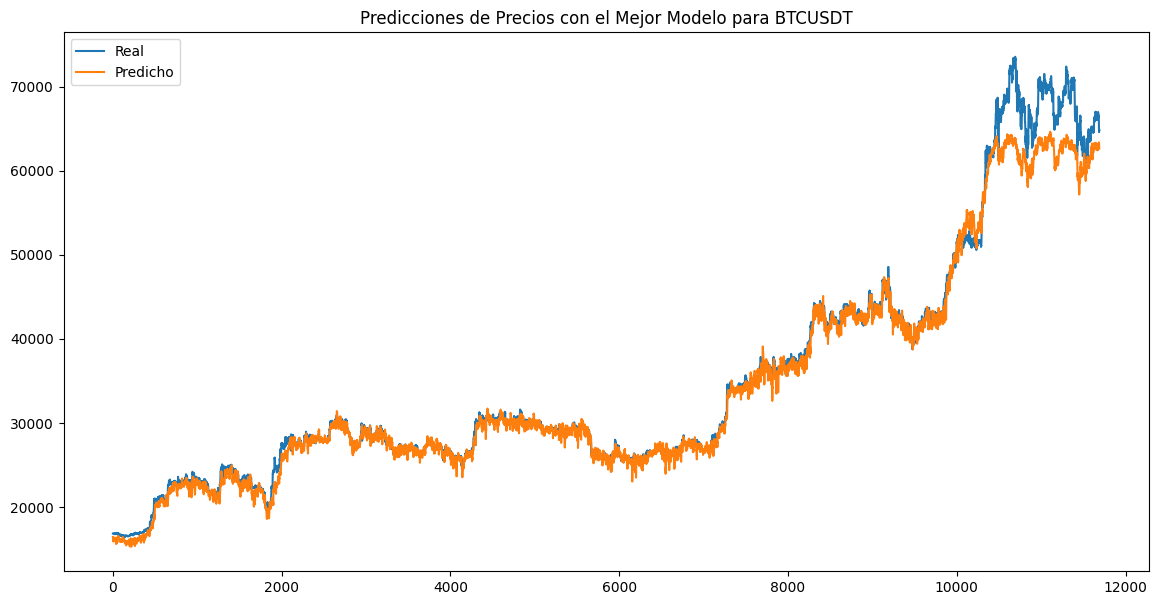

In [ ]:
# Para BTCUSDT
train_and_evaluate('BTCUSDT', model_dir, param_grid, sequence_length)


In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot as plt
import joblib

def evaluate_best_model(symbol, model_dir):
    # Cargar los datos preparados
    prepared_data_path = os.path.join("..//content/drive/My Drive/tradingcripto/data/processed", f"{symbol}_prepared_data.pkl")
    X_train, X_test, y_train, y_test, feature_scaler, target_scaler = joblib.load(prepared_data_path)

    # Definir la ruta del mejor modelo
    symbol_model_dir = os.path.join(model_dir, symbol)
    best_model_path = os.path.join(symbol_model_dir, "best_model.keras")

    if not os.path.exists(best_model_path):
        raise FileNotFoundError(f"No se encontró el mejor modelo guardado en: {best_model_path}")

    # Cargar el mejor modelo
    best_model = load_model(best_model_path)

    # Evaluar el mejor modelo
    predicted = best_model.predict(X_test)

    # Desnormalizar y_test y predicted
    y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    predicted_rescaled = target_scaler.inverse_transform(predicted.reshape(-1, 1))

    # Calcular métricas
    mse = mean_squared_error(y_test_rescaled, predicted_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predicted_rescaled)
    r2 = r2_score(y_test_rescaled, predicted_rescaled)

    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")

    # Graficar resultados
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_rescaled, label='Real')
    plt.plot(predicted_rescaled, label='Predicho')
    plt.title(f'Predicciones de Precios con el Mejor Modelo para {symbol}')
    plt.legend()
    plt.show()




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit

def analyze_folds(symbol, sequence_length=50):
    # Cargar los datos preparados
    prepared_data_path = os.path.join("..//content/drive/My Drive/tradingcripto/data/processed", f"{symbol}_prepared_data.pkl")
    X_train, X_test, y_train, y_test, feature_scaler, target_scaler = joblib.load(prepared_data_path)

    # Configurar la validación cruzada
    tscv = TimeSeriesSplit(n_splits=3)

    fold = 1
    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        print(f"Fold {fold}:")
        print(f"  Tamaño de X_train_fold: {X_train_fold.shape}")
        print(f"  Tamaño de X_val_fold: {X_val_fold.shape}")
        print(f"  Tamaño de y_train_fold: {y_train_fold.shape}")
        print(f"  Tamaño de y_val_fold: {y_val_fold.shape}")

        # Visualizar los datos
        plt.figure(figsize=(14, 7))
        plt.plot(y_train_fold, label='y_train_fold')
        plt.plot(range(len(y_train_fold), len(y_train_fold) + len(y_val_fold)), y_val_fold, label='y_val_fold')
        plt.title(f'Series Temporales para el Fold {fold}')
        plt.legend()
        plt.show()

        fold += 1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Fold 1:
  Tamaño de X_train_fold: (11691, 50, 57)
  Tamaño de X_val_fold: (11688, 50, 57)
  Tamaño de y_train_fold: (11691,)
  Tamaño de y_val_fold: (11688,)


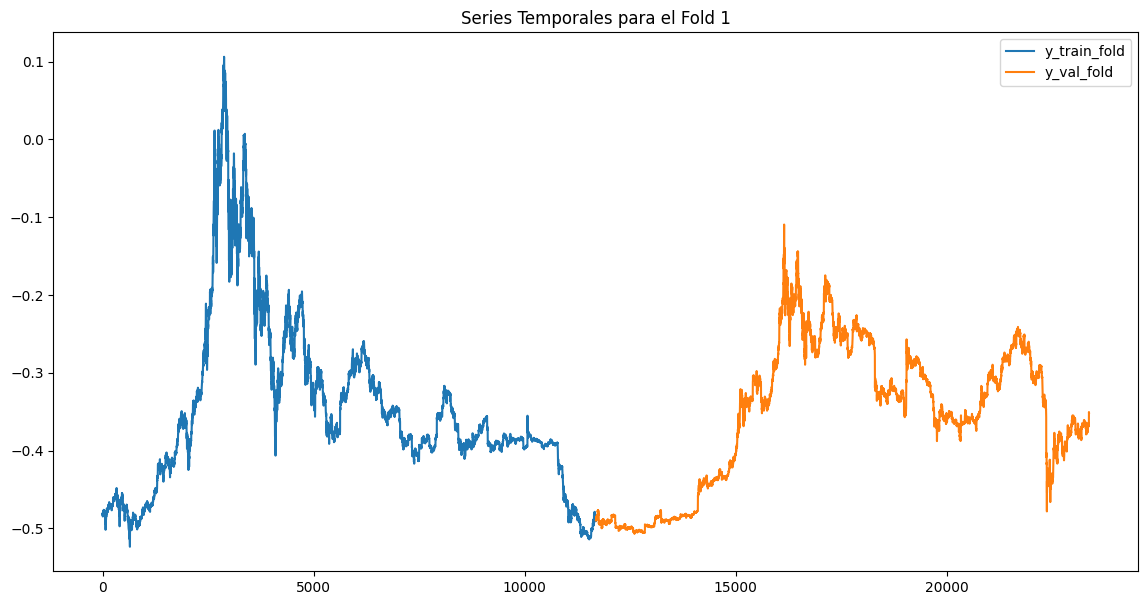

Fold 2:
  Tamaño de X_train_fold: (23379, 50, 57)
  Tamaño de X_val_fold: (11688, 50, 57)
  Tamaño de y_train_fold: (23379,)
  Tamaño de y_val_fold: (11688,)


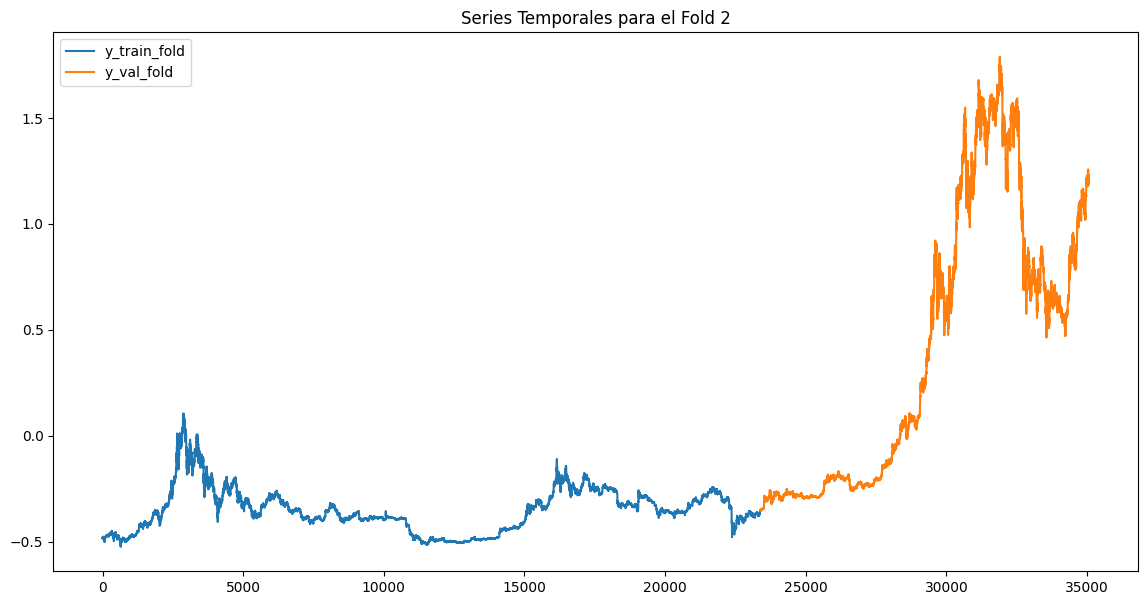

Fold 3:
  Tamaño de X_train_fold: (35067, 50, 57)
  Tamaño de X_val_fold: (11688, 50, 57)
  Tamaño de y_train_fold: (35067,)
  Tamaño de y_val_fold: (11688,)


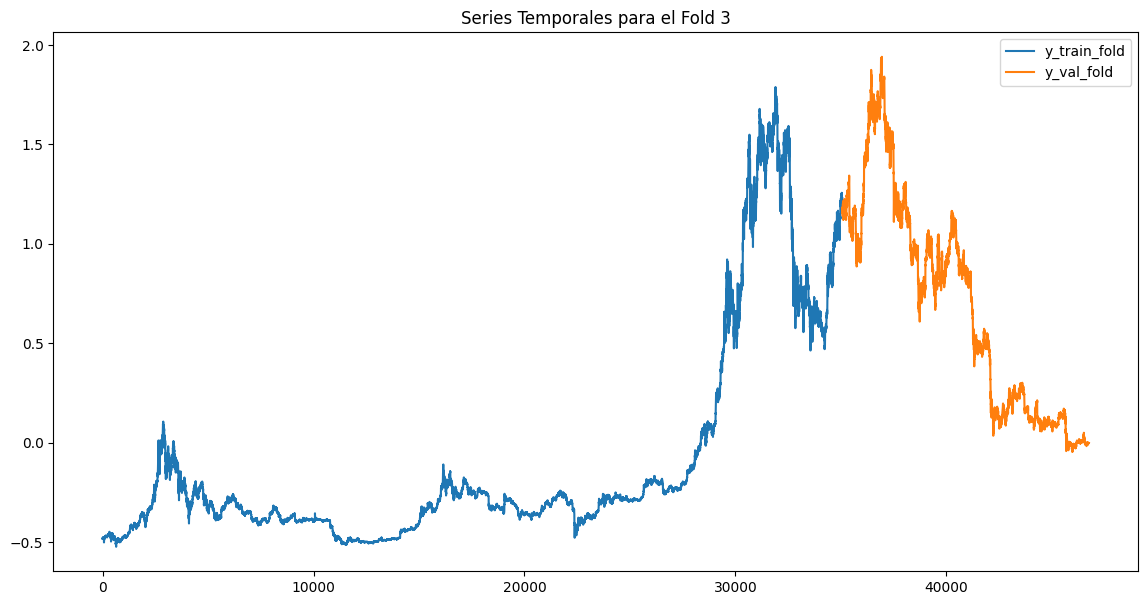

In [ ]:
# Usar la función para analizar los pliegues de BTCUSDT
analyze_folds('BTCUSDT')

366/366 [==============================] - 5s 7ms/step
MSE: 3886897.6135212383
MAE: 1066.7508895115066
R²: 0.9800788501841625


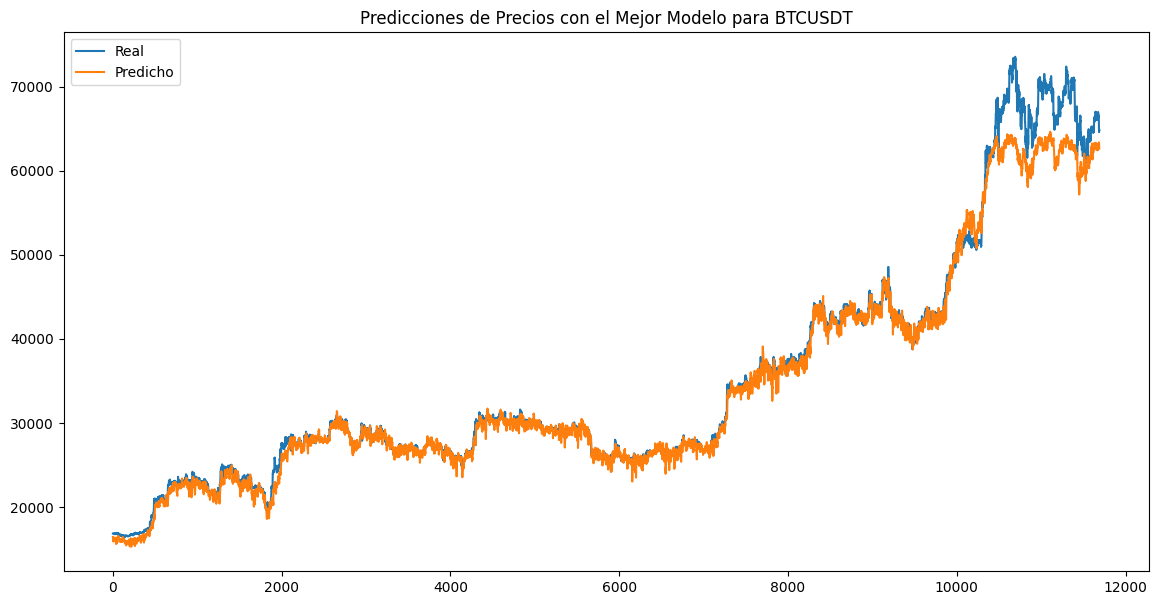

In [ ]:
# Uso de la función para evaluar el mejor modelo de BTCUSDT
evaluate_best_model('BTCUSDT', '/content/drive/My Drive/tradingcripto/models')

Entrenando y evaluando modelo para ETHUSDT


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch 1: loss = 0.038378287106752396, val_loss = 0.005456653423607349, mse = 0.038378287106752396, val_mse = 0.005456653423607349, mae = 0.10949927568435669, val_mae = 0.06462602317333221

Epoch 1: val_mae improved from inf to 0.06463, saving model to /content/drive/My Drive/tradingcripto/models/ETHUSDT/model_[256, 128, 64]_0.2_rmsprop_Bidirectional_LSTM_30_64_fold_0.keras
Epoch 2: loss = 0.004832562990486622, val_loss = 0.0035002657677978277, mse = 0.004832562990486622, val_mse = 0.0035002657677978277, mae = 0.05505882203578949, val_mae = 0.04963793605566025

Epoch 2: val_mae improved from 0.06463 to 0.04964, saving model to /content/drive/My Drive/tradingcripto/models/ETHUSDT/model_[256, 128, 64]_0.2_rmsprop_Bidirectional_LSTM_30_64_fold_0.keras
Epoch 3: loss = 0.002927420660853386, val_loss = 0.004700406454503536, mse = 0.002927420660853386, val_mse = 0.004700406454503536, mae = 0.043148960918188095, val_mae = 0.06143605336546898

Epoch 3: val_mae did not improve from 0.04964
Epoch 

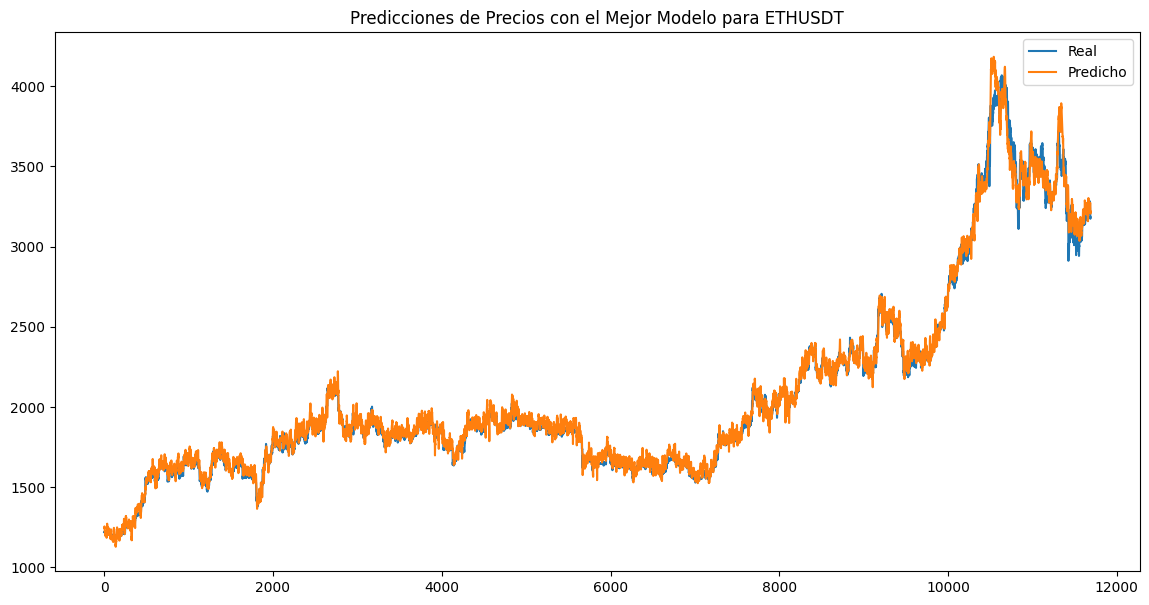

In [ ]:
# Para ETHUSDT
train_and_evaluate('ETHUSDT', model_dir, param_grid, sequence_length)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Fold 1:
  Tamaño de X_train_fold: (11691, 50, 57)
  Tamaño de X_val_fold: (11688, 50, 57)
  Tamaño de y_train_fold: (11691,)
  Tamaño de y_val_fold: (11688,)


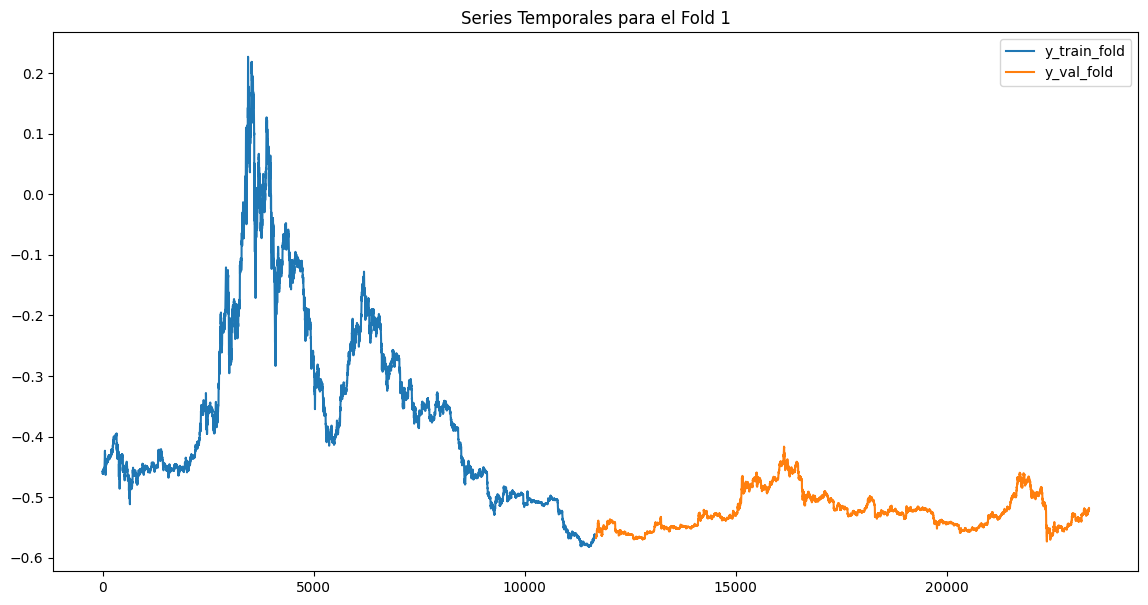

Fold 2:
  Tamaño de X_train_fold: (23379, 50, 57)
  Tamaño de X_val_fold: (11688, 50, 57)
  Tamaño de y_train_fold: (23379,)
  Tamaño de y_val_fold: (11688,)


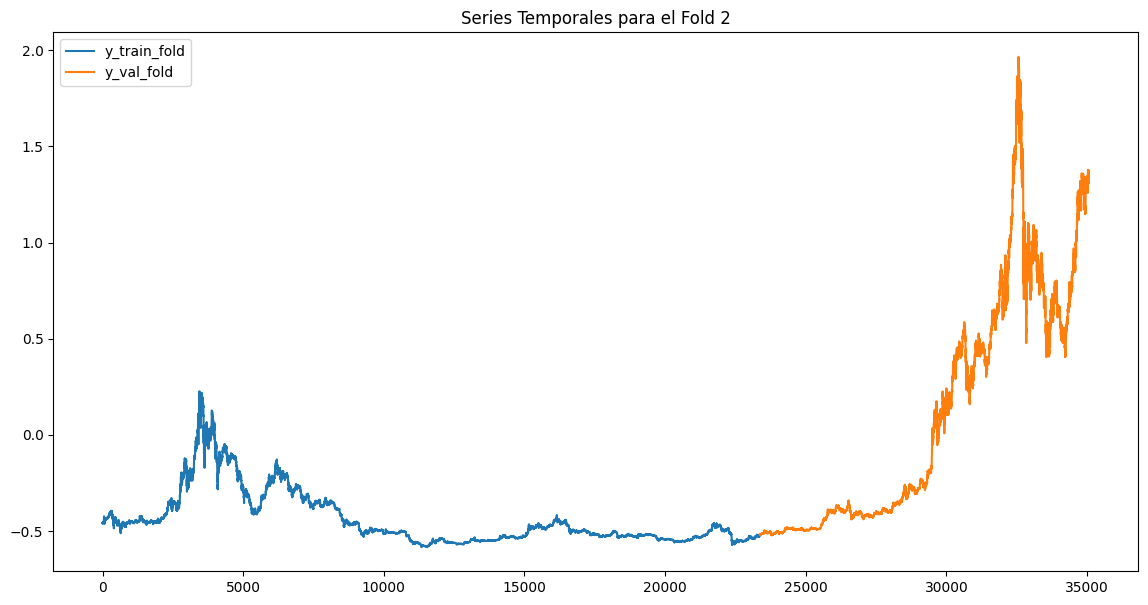

Fold 3:
  Tamaño de X_train_fold: (35067, 50, 57)
  Tamaño de X_val_fold: (11688, 50, 57)
  Tamaño de y_train_fold: (35067,)
  Tamaño de y_val_fold: (11688,)


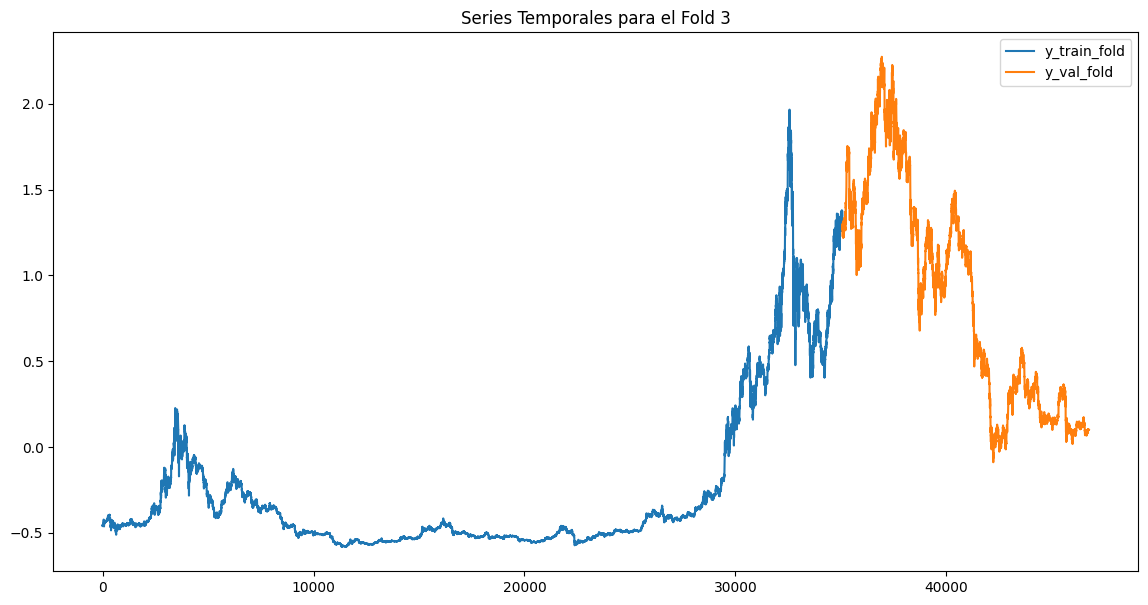

In [ ]:
# Usar la función para analizar los pliegues de ETHUSDT
analyze_folds('ETHUSDT')

366/366 [==============================] - 4s 7ms/step
MSE: 3122.290911673305
MAE: 39.64126276198176
R²: 0.9916495075686741


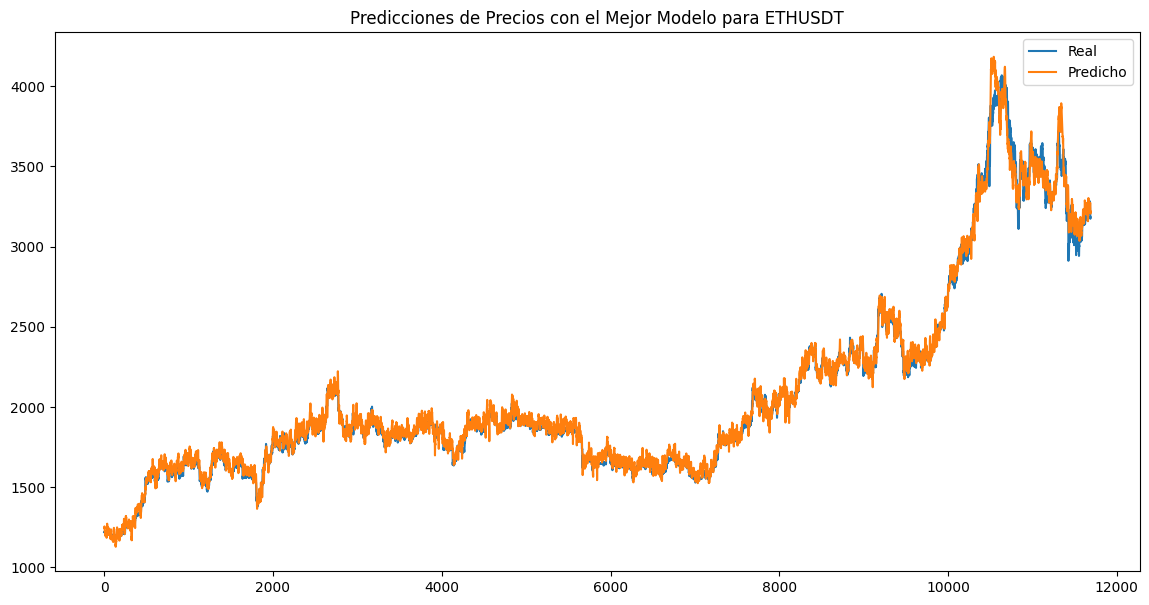

In [ ]:
# Uso de la función para evaluar el mejor modelo de ETHUSDT
evaluate_best_model('ETHUSDT', '/content/drive/My Drive/tradingcripto/models')

Entrenando y evaluando modelo para XRPUSDT


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch 1: loss = 0.0308747049421072, val_loss = 0.035334374755620956, mse = 0.0308747049421072, val_mse = 0.035334374755620956, mae = 0.1113695427775383, val_mae = 0.16574282944202423

Epoch 1: val_mae improved from inf to 0.16574, saving model to /content/drive/My Drive/tradingcripto/models/XRPUSDT/model_[256, 128, 64]_0.2_rmsprop_Bidirectional_LSTM_30_64_fold_0.keras
Epoch 2: loss = 0.0071775224059820175, val_loss = 0.010284887626767159, mse = 0.0071775224059820175, val_mse = 0.010284887626767159, mae = 0.06424865871667862, val_mae = 0.08005262166261673

Epoch 2: val_mae improved from 0.16574 to 0.08005, saving model to /content/drive/My Drive/tradingcripto/models/XRPUSDT/model_[256, 128, 64]_0.2_rmsprop_Bidirectional_LSTM_30_64_fold_0.keras
Epoch 3: loss = 0.004849867895245552, val_loss = 0.05364111810922623, mse = 0.004849867895245552, val_mse = 0.05364111810922623, mae = 0.05277428776025772, val_mae = 0.21733799576759338

Epoch 3: val_mae did not improve from 0.08005
Epoch 4: loss 

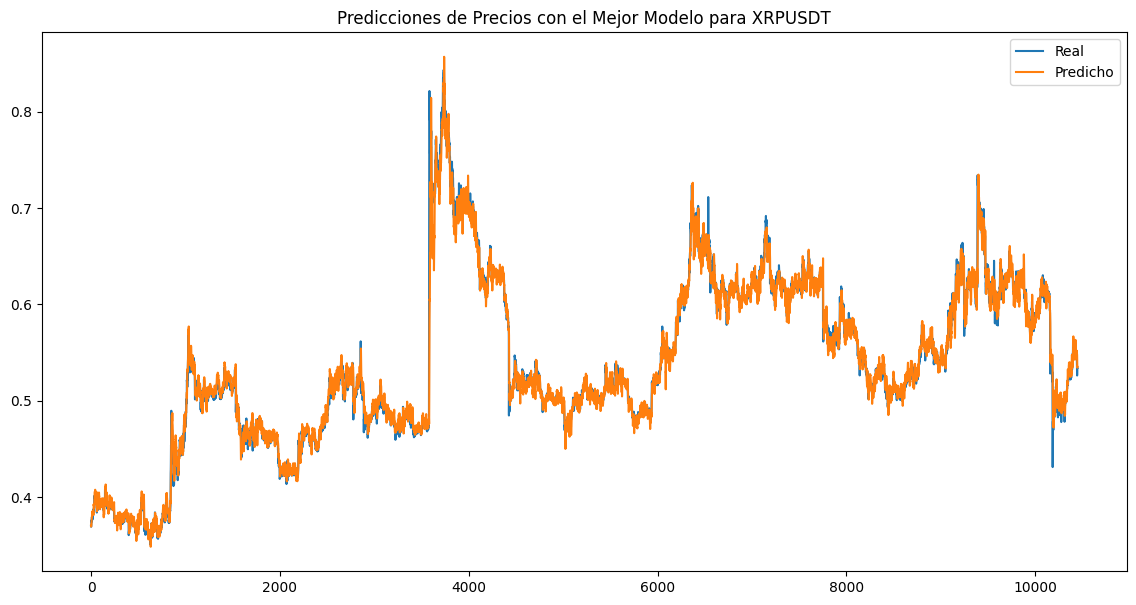

In [ ]:
# Para XRPUSDT
train_and_evaluate('XRPUSDT', model_dir, param_grid, sequence_length)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Fold 1:
  Tamaño de X_train_fold: (10448, 50, 57)
  Tamaño de X_val_fold: (10448, 50, 57)
  Tamaño de y_train_fold: (10448,)
  Tamaño de y_val_fold: (10448,)


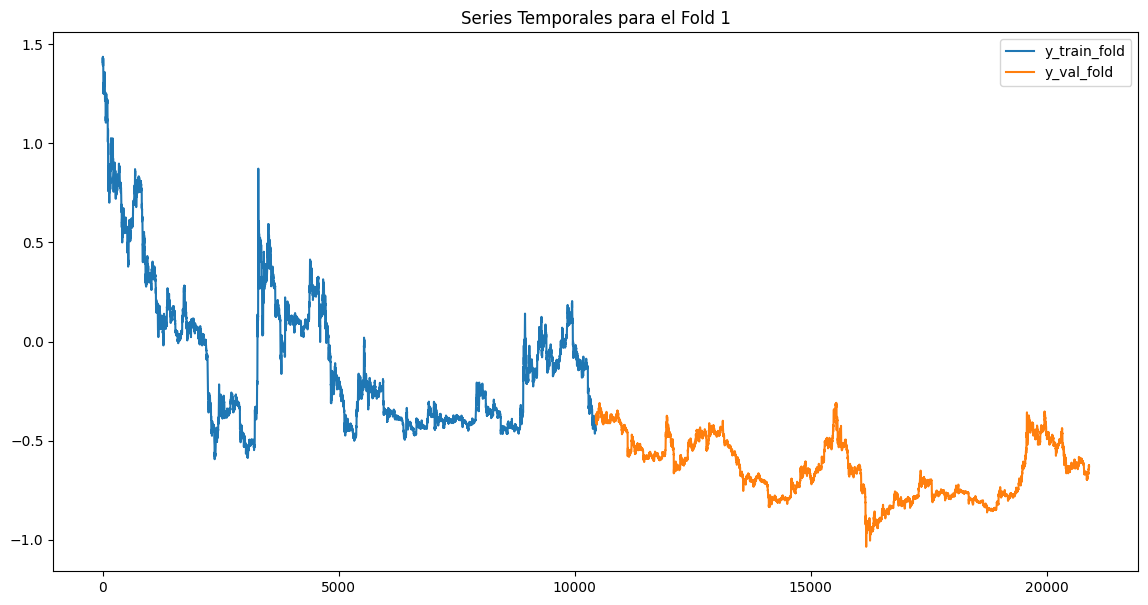

Fold 2:
  Tamaño de X_train_fold: (20896, 50, 57)
  Tamaño de X_val_fold: (10448, 50, 57)
  Tamaño de y_train_fold: (20896,)
  Tamaño de y_val_fold: (10448,)


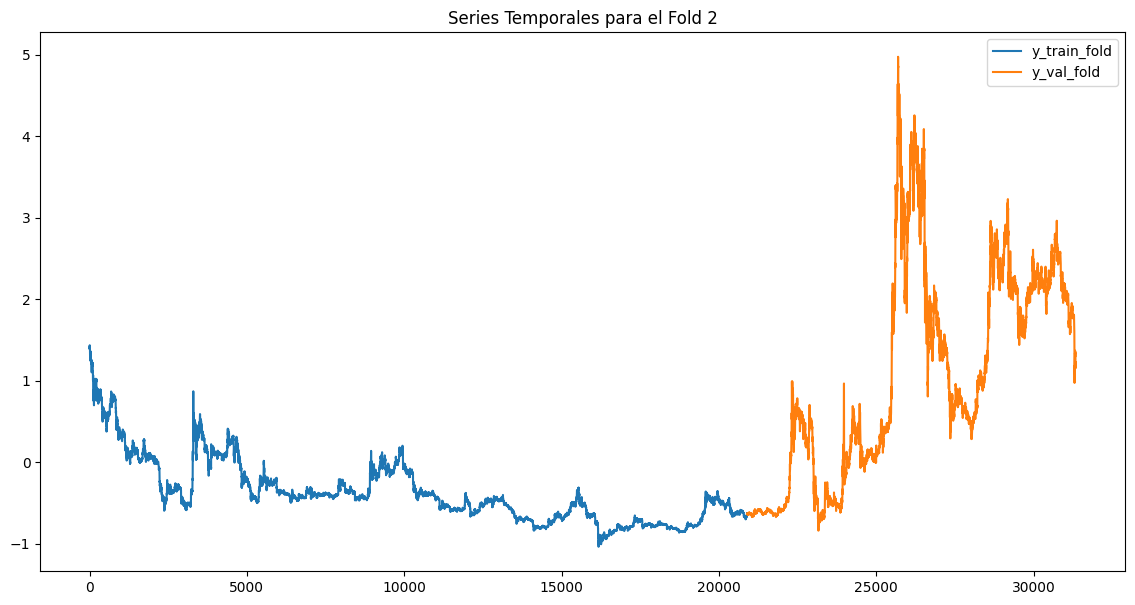

Fold 3:
  Tamaño de X_train_fold: (31344, 50, 57)
  Tamaño de X_val_fold: (10448, 50, 57)
  Tamaño de y_train_fold: (31344,)
  Tamaño de y_val_fold: (10448,)


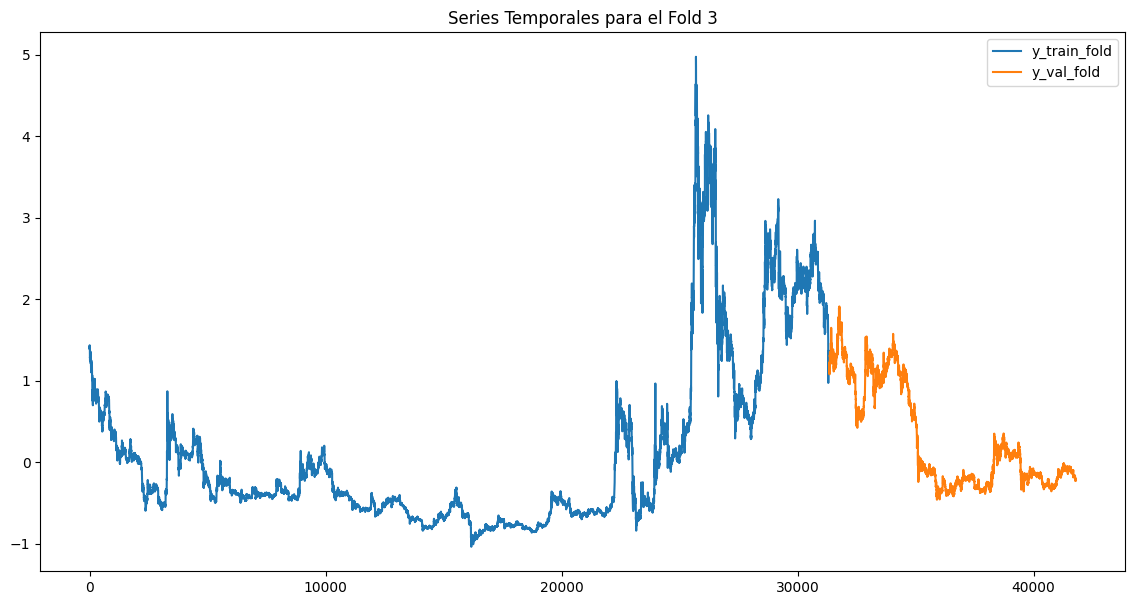

In [ ]:
# Usar la función para analizar los pliegues de XRPUSDT
analyze_folds('XRPUSDT')

327/327 [==============================] - 4s 7ms/step
MSE: 0.00012998582985946635
MAE: 0.006430341750593317
R²: 0.9829269805129457


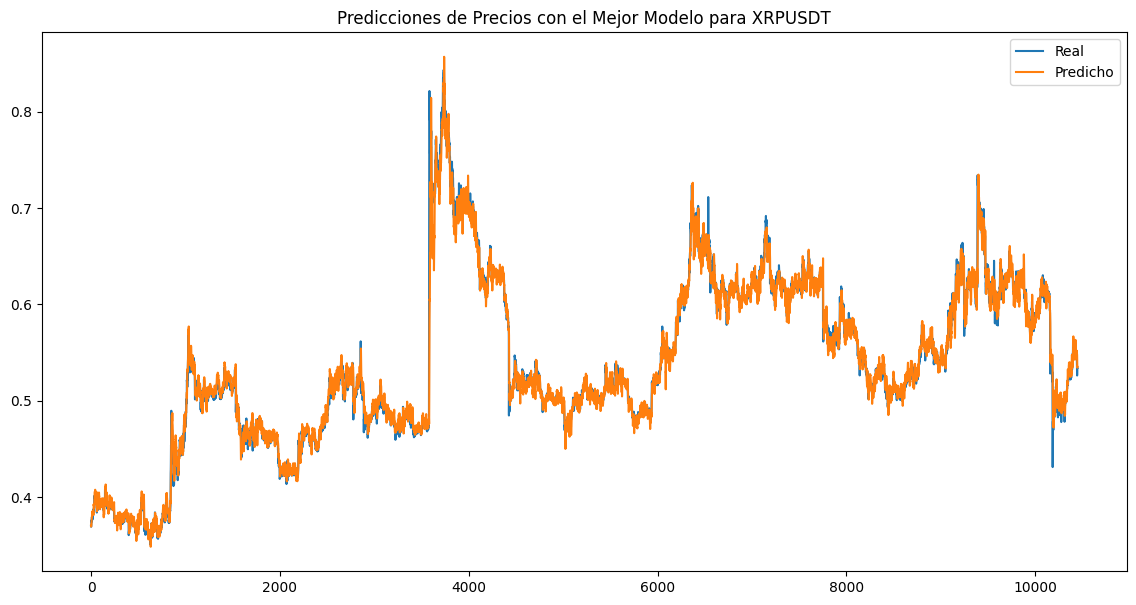

In [ ]:
# Uso de la función para evaluar el mejor modelo de XRPUSDT
evaluate_best_model('XRPUSDT', '/content/drive/My Drive/tradingcripto/models')

Entrenando y evaluando modelo para LTCUSDT


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch 1: loss = 0.09883636981248856, val_loss = 0.01883378066122532, mse = 0.09883636981248856, val_mse = 0.01883378066122532, mae = 0.20474761724472046, val_mae = 0.11545278877019882

Epoch 1: val_mae improved from inf to 0.11545, saving model to /content/drive/My Drive/tradingcripto/models/LTCUSDT/model_[256, 128, 64]_0.2_rmsprop_Bidirectional_LSTM_30_64_fold_0.keras
Epoch 2: loss = 0.036391355097293854, val_loss = 0.008090822026133537, mse = 0.036391355097293854, val_mse = 0.008090822026133537, mae = 0.13476867973804474, val_mae = 0.07710137218236923

Epoch 2: val_mae improved from 0.11545 to 0.07710, saving model to /content/drive/My Drive/tradingcripto/models/LTCUSDT/model_[256, 128, 64]_0.2_rmsprop_Bidirectional_LSTM_30_64_fold_0.keras
Epoch 3: loss = 0.025589266791939735, val_loss = 0.005496773403137922, mse = 0.025589266791939735, val_mse = 0.005496773403137922, mae = 0.1122998297214508, val_mae = 0.0624007023870945

Epoch 3: val_mae improved from 0.07710 to 0.06240, saving mod

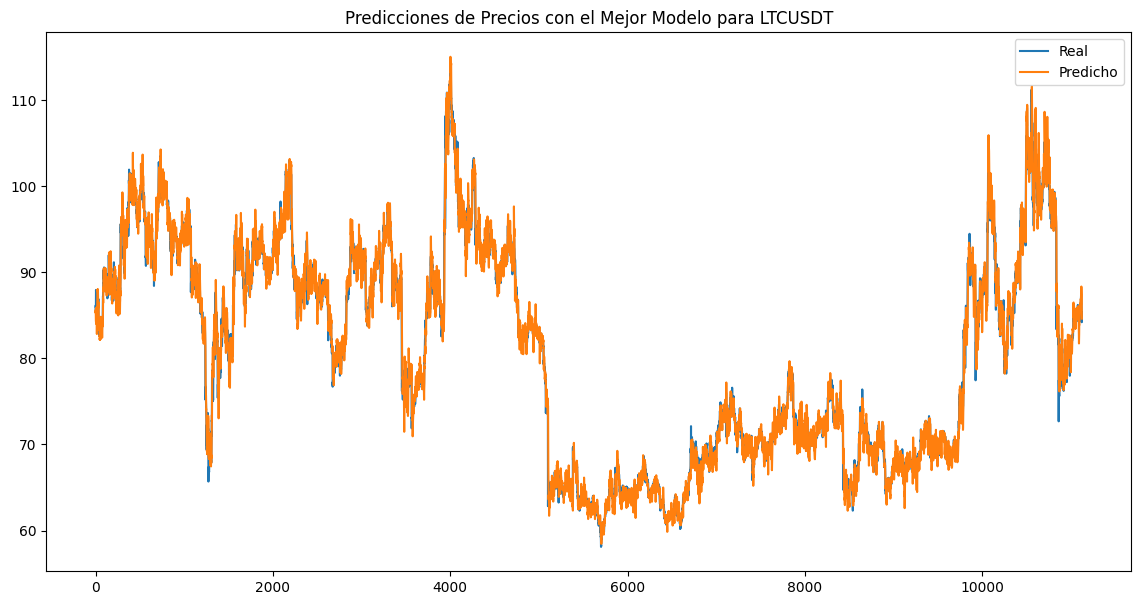

In [ ]:
# Para LTCUSDT
train_and_evaluate('LTCUSDT', model_dir, param_grid, sequence_length)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Fold 1:
  Tamaño de X_train_fold: (11126, 50, 57)
  Tamaño de X_val_fold: (11123, 50, 57)
  Tamaño de y_train_fold: (11126,)
  Tamaño de y_val_fold: (11123,)


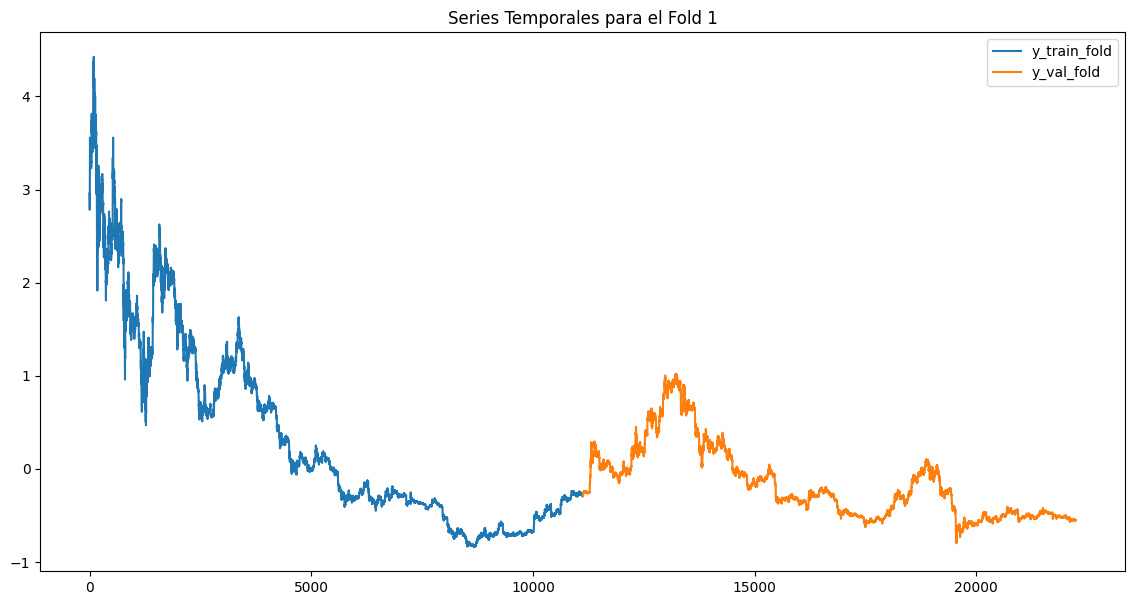

Fold 2:
  Tamaño de X_train_fold: (22249, 50, 57)
  Tamaño de X_val_fold: (11123, 50, 57)
  Tamaño de y_train_fold: (22249,)
  Tamaño de y_val_fold: (11123,)


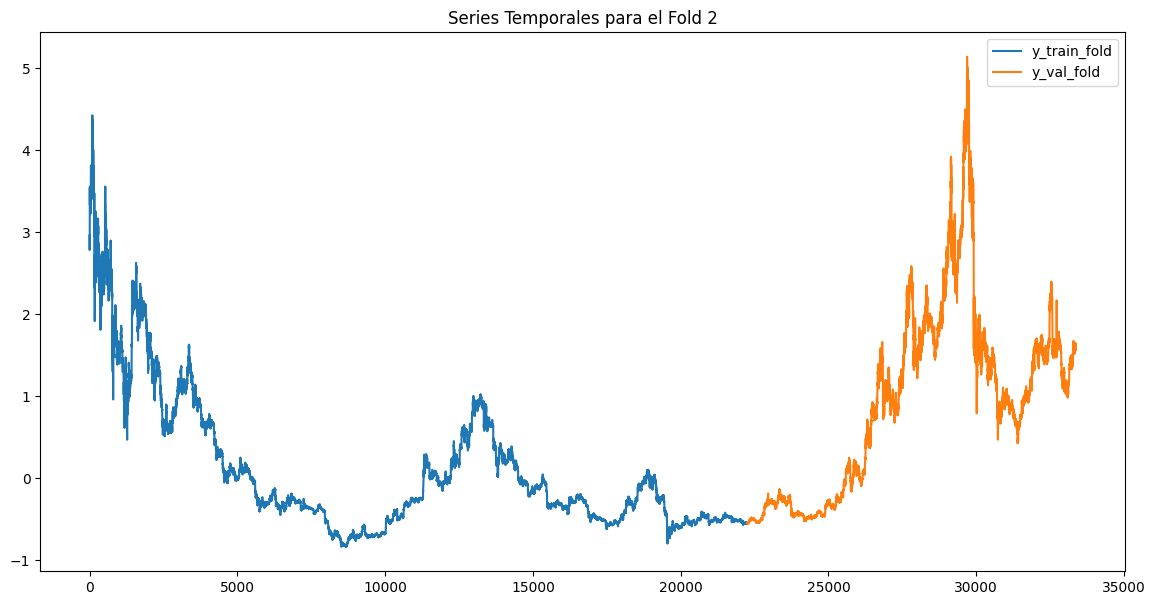

Fold 3:
  Tamaño de X_train_fold: (33372, 50, 57)
  Tamaño de X_val_fold: (11123, 50, 57)
  Tamaño de y_train_fold: (33372,)
  Tamaño de y_val_fold: (11123,)


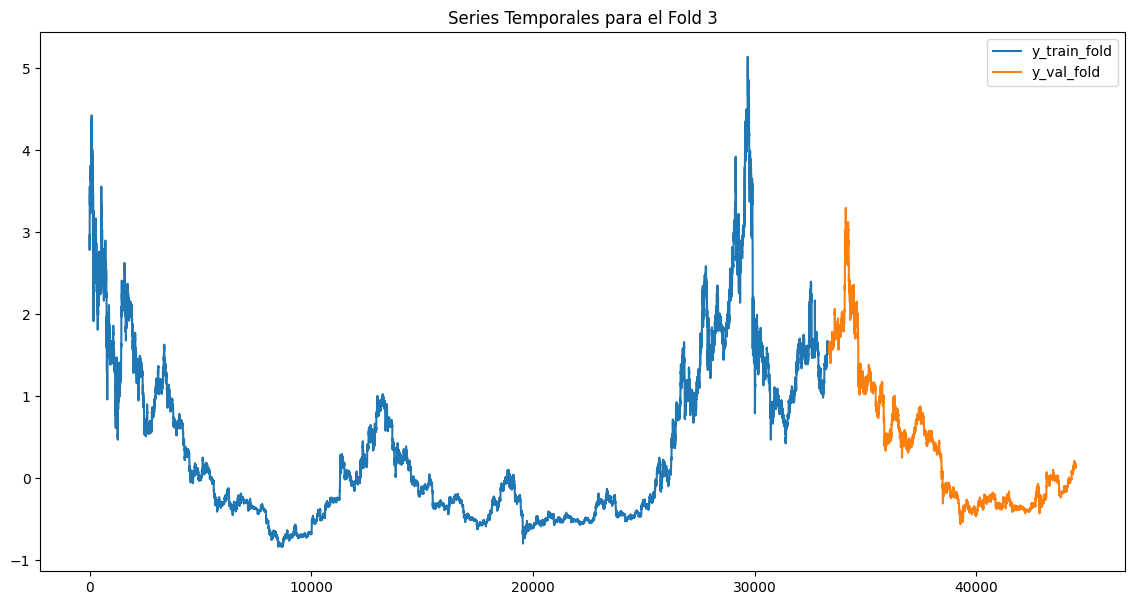

In [ ]:
# Usar la función para analizar los pliegues de LTCUSDT
analyze_folds('LTCUSDT')

348/348 [==============================] - 4s 7ms/step
MSE: 1.841382331279538
MAE: 0.9638946351590064
R²: 0.9877170135720514


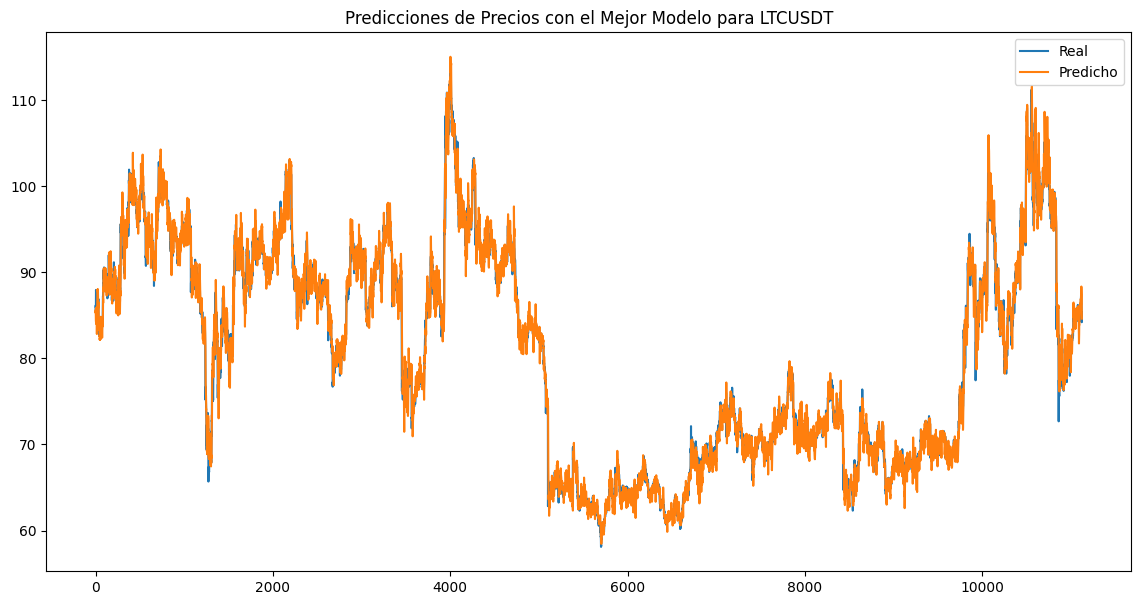

In [ ]:
# Uso de la función para evaluar el mejor modelo de LTCUSDT
evaluate_best_model('LTCUSDT', '/content/drive/My Drive/tradingcripto/models')

In [ ]:
import json
from tensorflow.keras.models import load_model
import os

def load_best_params_from_models(model_dir, symbols):
    best_params_dict = {}

    for symbol in symbols:
        symbol_model_dir = os.path.join(model_dir, symbol)
        best_model_path = os.path.join(symbol_model_dir, "best_model.keras")

        if os.path.exists(best_model_path):
            # Load the best model
            model = load_model(best_model_path)
            print(f"Loaded model for {symbol} from {best_model_path}")

            # Load the best params if they were saved separately
            best_params_path = os.path.join(symbol_model_dir, "best_params.json")
            if os.path.exists(best_params_path):
                with open(best_params_path, 'r') as f:
                    best_params = json.load(f)
                    best_params_dict[symbol] = best_params
                    print(f"Loaded best params for {symbol} from {best_params_path}")
            else:
                print(f"Best params for {symbol} not found.")
        else:
            print(f"Model for {symbol} not found at {best_model_path}")

    return best_params_dict


In [ ]:
# Define the path to save the models
model_dir = os.path.abspath("/content/drive/My Drive/tradingcripto/models")
symbols = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT']  # Lista de símbolos a evaluar

# Load the best parameters from the saved models
best_params_dict = load_best_params_from_models(model_dir, symbols)

# Define a new param_grid for fine-tuning each symbol
fine_tune_param_grids = {}
for symbol, params in best_params_dict.items():
    fine_tune_param_grids[symbol] = {
        'units': [params['units'] - 10, params['units'], params['units'] + 10],
        'dropout_rate': [max(0, params['dropout_rate'] - 0.1), params['dropout_rate'], min(1, params['dropout_rate'] + 0.1)],
        'optimizer': [params['optimizer']],
        'model_type': [params['model_type']],
        'epochs': [60],
        'batch_size': [params['batch_size']]
    }


Model for BTCUSDT not found at /content/drive/My Drive/tradingcripto/models/BTCUSDT/best_model.keras
Model for ETHUSDT not found at /content/drive/My Drive/tradingcripto/models/ETHUSDT/best_model.keras
Model for XRPUSDT not found at /content/drive/My Drive/tradingcripto/models/XRPUSDT/best_model.keras
Model for LTCUSDT not found at /content/drive/My Drive/tradingcripto/models/LTCUSDT/best_model.keras


In [ ]:
# Perform fine-tuning for each symbol
for symbol in symbols:
    if symbol in fine_tune_param_grids:
        print(f"Fine-tuning model for {symbol}")
        fine_tune_param_grid = fine_tune_param_grids[symbol]
        train_and_evaluate(symbol, model_dir, fine_tune_param_grid, sequence_length)
    else:
        print(f"No best params found for {symbol}, skipping fine-tuning.")


No best params found for BTCUSDT, skipping fine-tuning.
No best params found for ETHUSDT, skipping fine-tuning.
No best params found for XRPUSDT, skipping fine-tuning.
No best params found for LTCUSDT, skipping fine-tuning.


In [1]:
import streamlit as st
import ccxt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from keras.models import load_model
import talib
import os
from datetime import datetime

def fetch_latest_data_kraken(symbol, limit):
    exchange = ccxt.kraken()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe='1h', limit=limit)
    data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    return data

def initialize_support_resistance(df):
    df['support'] = df['low'].rolling(window=30).min()
    df['resistance'] = df['high'].rolling(window=30).max()
    df['dynamic_support'] = df['low'].rolling(window=5).min()
    df['dynamic_resistance'] = df['high'].rolling(window=5).max()
    return df

def preprocess_data(df):
    df['sma_7'] = df['close'].rolling(window=7).mean()
    df['ema_7'] = df['close'].ewm(span=7, adjust=False).mean()
    df['sma_14'] = df['close'].rolling(window=14).mean()
    df['ema_14'] = df['close'].ewm(span=14, adjust=False).mean()
    df['sma_21'] = df['close'].rolling(window=21).mean()
    df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()
    df['sma_28'] = df['close'].rolling(window=28).mean()
    df['ema_28'] = df['close'].ewm(span=28, adjust=False).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['sma_100'] = df['close'].rolling(window=100).mean()
    df['ema_100'] = df['close'].ewm(span=100, adjust=False).mean()
    df['sma_200'] = df['close'].rolling(window=200).mean()
    df['ema_200'] = df['close'].ewm(span=200, adjust=False).mean()
    df['rsi_14'] = talib.RSI(df['close'], timeperiod=14)
    df['macd'], df['macd_signal'], df['macd_diff'] = talib.MACD(df['close'])
    df['willr'] = talib.WILLR(df['high'], df['low'], df['close'], timeperiod=14)
    df['atr_14'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['adx'] = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
    df['cci'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)
    df['ichimoku_a'] = (talib.MIN(df['low'], timeperiod=9) + talib.MAX(df['high'], timeperiod=9)) / 2
    df['ichimoku_b'] = (talib.MIN(df['low'], timeperiod=26) + talib.MAX(df['high'], timeperiod=26)) / 2
    df['momentum_10'] = talib.MOM(df['close'], timeperiod=10)
    df['momentum_14'] = talib.MOM(df['close'], timeperiod=14)
    df['momentum_20'] = talib.MOM(df['close'], timeperiod=20)
    df['momentum_30'] = talib.MOM(df['close'], timeperiod=30)
    df['keltner_hband'] = talib.MA((df['high'] + df['low'] + df['close']) / 3 + 2 * df['atr_14'], timeperiod=10)
    df['keltner_lband'] = talib.MA((df['high'] + df['low'] + df['close']) / 3 - 2 * df['atr_14'], timeperiod=10)
    df['doji'] = talib.CDLDOJI(df['open'], df['high'], df['low'], df['close'])
    df['engulfing'] = talib.CDLENGULFING(df['open'], df['high'], df['low'], df['close'])
    df['hammer'] = talib.CDLHAMMER(df['open'], df['high'], df['low'], df['close'])
    df['inverted_hammer'] = talib.CDLINVERTEDHAMMER(df['open'], df['high'], df['low'], df['close'])
    df['hanging_man'] = talib.CDLHANGINGMAN(df['open'], df['high'], df['low'], df['close'])
    df['shooting_star'] = talib.CDLSHOOTINGSTAR(df['open'], df['high'], df['low'], df['close'])
    df['morning_star'] = talib.CDLMORNINGSTAR(df['open'], df['high'], df['low'], df['close'])
    df['evening_star'] = talib.CDLEVENINGSTAR(df['open'], df['high'], df['low'], df['close'])
    df['morning_doji_star'] = talib.CDLMORNINGDOJISTAR(df['open'], df['high'], df['low'], df['close'])
    df['evening_doji_star'] = talib.CDLEVENINGDOJISTAR(df['open'], df['high'], df['low'], df['close'])
    df['piercing_line'] = talib.CDLPIERCING(df['open'], df['high'], df['low'], df['close'])
    df['dark_cloud_cover'] = talib.CDLDARKCLOUDCOVER(df['open'], df['high'], df['low'], df['close'])
    df['three_white_soldiers'] = talib.CDL3WHITESOLDIERS(df['open'], df['high'], df['low'], df['close'])
    df['three_black_crows'] = talib.CDL3BLACKCROWS(df['open'], df['high'], df['low'], df['close'])
    df['three_inside_up_down'] = talib.CDL3INSIDE(df['open'], df['high'], df['low'], df['close'])
    df['three_outside_up_down'] = talib.CDL3OUTSIDE(df['open'], df['high'], df['low'], df['close'])
    df['three_stars_in_the_south'] = talib.CDL3STARSINSOUTH(df['open'], df['high'], df['low'], df['close'])
    df['three_advancing_white_soldiers'] = talib.CDLADVANCEBLOCK(df['open'], df['high'], df['low'], df['close'])

    df = df.fillna(0)
    return df

def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X[i:i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(xs), np.array(ys)

def trading_strategy(df, mape_threshold, buy_threshold, sell_threshold, stop_loss_percentage):
    signals = []
    confidences = []
    stop_losses = []
    for i in range(len(df) - 1):
        if df['MAPE'][i] > mape_threshold:
            signals.append('No hacer nada')
            confidences.append(0)
            stop_losses.append(np.nan)
        else:
            confidence = abs(df['corrected_prediction'][i+1] - df['close'][i]) / df['close'][i]
            confidences.append(confidence)
            if df['corrected_prediction'][i+1] > df['close'][i] + buy_threshold:
                signals.append('Comprar')
                stop_loss = df['close'][i] * (1 - stop_loss_percentage)
                stop_losses.append(stop_loss)
            elif df['corrected_prediction'][i+1] < df['close'][i] - sell_threshold:
                signals.append('Vender')
                stop_losses.append(np.nan)
            else:
                signals.append('Mantener')
                stop_losses.append(np.nan)
    signals.append('Mantener')
    confidences.append(0)
    stop_losses.append(np.nan)
    return signals, confidences, stop_losses

def main():
    st.title('Aplicación de Trading')
    symbol = 'BTC/USDT'
    limit = 60000
    mape_threshold = 3  # Umbral de MAPE para no hacer nada
    buy_threshold = 0.01  # Umbral para señal de compra
    sell_threshold = 0.01  # Umbral para señal de venta
    stop_loss_percentage = 0.02  # Stop-loss al 2% del precio de compra

    df = fetch_latest_data_kraken(symbol, limit)
    df = initialize_support_resistance(df)
    df = preprocess_data(df)

    df['next_close'] = df['close'].shift(-1)

    features = df.drop(columns=['next_close'])
    target = df['next_close']

    scaler = RobustScaler()
    features_scaled = scaler.fit_transform(features)
    target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

    seq_length = 50
    X, y = create_sequences(features_scaled, target_scaled, seq_length)

    model_path = f'../models/best_model_BTCUSDT.keras'
    model = load_model(model_path)

    # Asegúrate de que la forma de entrada es correcta para el modelo
    if X.shape[1:] != model.input_shape[1:]:
        st.error(f"Shape mismatch: X shape is {X.shape[1:]}, model expects {model.input_shape[1:]}")
        return

    # Predicción para los últimos 20 valores
    predictions = []
    for i in range(20):
        input_data = X[-(20-i)].reshape(1, seq_length, features_scaled.shape[1])
        pred = model.predict(input_data)
        predictions.append(scaler.inverse_transform(pred)[0][0])

    # Agregar predicciones al DataFrame original para comparación
    df['predictions'] = np.nan
    df.iloc[-20:, df.columns.get_loc('predictions')] = predictions

    # Calcular MAPE
    actual = df['next_close'].iloc[-20:]
    predicted = df['predictions'].iloc[-20:]
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    # Ajuste de predicciones basado en MAPE
    df['corrected_prediction'] = df['predictions'] * (1 + mape / 100)

    # Generar señales de trading y stop-loss
    df['MAPE'] = mape
    df['signal'], df['confidence'], df['stop_loss'] = trading_strategy(df, mape_threshold, buy_threshold, sell_threshold, stop_loss_percentage)

    # Restablecer el índice para que 'timestamp' esté disponible como columna
    df.reset_index(inplace=True)

    # Mostrar la tabla en Streamlit
    st.write(df[['timestamp', 'close', 'next_close', 'predictions', 'corrected_prediction', 'signal', 'confidence', 'stop_loss']].tail(20))

    # Mostrar señales de trading en Streamlit
    st.write("Señales de Trading:")
    for index, row in df[['timestamp', 'signal', 'confidence', 'stop_loss']].tail(20).iterrows():
        st.write(f"Timestamp: {row['timestamp']}, Señal: {row['signal']}, Confianza: {row['confidence']:.2f}, Stop-Loss: {row['stop_loss']}")

    # Advertir si falta poco tiempo para el cierre de la hora
    current_time = datetime.now()
    if current_time.minute > 20:
        st.warning("Faltan menos de 40 minutos para el cierre de la hora actual. Es mejor pedir información en la siguiente hora.")

    # Imprimir las últimas 20 sesiones con los datos relevantes
    print(df[['timestamp', 'close', 'next_close', 'predictions', 'corrected_prediction', 'MAPE', 'signal', 'confidence', 'stop_loss']].tail(20))

if __name__ == "__main__":
    main()


2024-05-22 12:29:05.827305: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 12:29:05.867356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 12:29:05.867407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 12:29:05.868707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 12:29:05.874950: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 12:29:05.876011: I tensorflow/core/platform/cpu_feature_guard.cc:1

1/1 [==============================] - 0s 33ms/step
              timestamp    close  next_close   predictions  \
700 2024-05-21 17:00:00  69838.1     69823.5  67995.031250   
701 2024-05-21 18:00:00  69823.5     69258.4  68061.890625   
702 2024-05-21 19:00:00  69258.4     69744.7  68008.734375   
703 2024-05-21 20:00:00  69744.7     69742.5  67960.773438   
704 2024-05-21 21:00:00  69742.5     70212.8  67973.875000   
705 2024-05-21 22:00:00  70212.8     70145.9  67930.375000   
706 2024-05-21 23:00:00  70145.9     70130.1  67998.570312   
707 2024-05-22 00:00:00  70130.1     70136.2  67974.531250   
708 2024-05-22 01:00:00  70136.2     70024.1  68003.851562   
709 2024-05-22 02:00:00  70024.1     69943.8  67944.093750   
710 2024-05-22 03:00:00  69943.8     69544.7  67994.390625   
711 2024-05-22 04:00:00  69544.7     69865.0  67954.789062   
712 2024-05-22 05:00:00  69865.0     69842.0  67944.617188   
713 2024-05-22 06:00:00  69842.0     69712.7  68039.406250   
714 2024-05-22 07:

/tmp/ipykernel_71368/3793148078.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['MAPE'][i] > mape_threshold:
/tmp/ipykernel_71368/3793148078.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  confidence = abs(df['corrected_prediction'][i+1] - df['close'][i]) / df['close'][i]
/tmp/ipykernel_71368/3793148078.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['corrected_prediction'][i+1] > df['close'][i] + buy_thre